# Problem set 2 (45 + 50 + 33 + 15 = 143 pts)

## Problem 1 (LU decomposition) 45 pts


### 1. LU  for band matrices and Cholesky decomposition (13 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of matrices –– band matrices with top left entry equal to 1 and the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively. The bands may be ```[1, 2, 1]``` and ```[1, 1, 2, 1, 1]``` respectively

- (4 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with top left entry equal to 1 with given diagonal bands. 
For example, input parametres ```(diag_broadcast = [1,2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$A = \begin{pmatrix}
1 & 1 & 0 & 0\\
1 & 2 & 1 & 0 \\
0 & 1 & 2 & 1 \\
0 & 0 & 1 & 2 \\
\end{pmatrix}.$$

Provide the extensive testing of the implemented function that will works correctly for large $n$,  e.g. $n=100$.
As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).

- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

- (7 pts) Write a function ```cholesky(n)``` for computing Cholesky decomposition. It should take the the single argument - the matrix that will be factorized and return the single output - lower-triangular factor $L$. Think about the efficiency of your implementation and if necessary update it to achieve the best performance (eliminate Python loops, where it is possible and so on). Explicitly describe the difference with LU decomposition that reduces the complexity from $2n^3/3$ for LU to $n^3/3$ for Cholesky. 
Test the implemented function on the Pascal matrix of given size $n$ for $n = 5, 10, 50$. 
Pascal matrix is square matrix of the following form (here for $n=4$)
$$P = \begin{pmatrix}
1 & 1 & 1 & 1\\
1 & 2 & 3 & 4 \\
1 & 3 & 6 & 10 \\
1 & 4 & 10 & 20 \\
\end{pmatrix}.$$

    [Here](https://en.wikipedia.org/wiki/Pascal_matrix) you can find more details about such matrices and analytical form for factor $L$ from Cholesky decomposition. Compare the result of your implementation with analytical expression in terms of some matrix norm of difference.  

In [1]:
from scipy.sparse import diags # can be used with broadcasting of scalars if desired dimensions are large
import numpy as np

# INPUT : diag_broadcast - list of diagonals value to broadcast,length equal to 3 or 5; n - integer, band matrix shape.
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n-1, do not store main diagonal, where all ones;                  add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.

def band_lu(diag_broadcast, n):
    if len(diag_broadcast) == 3:
        # i - number of a row, k = i+1
        # ui - entries of a main diagonal of U
        # lk - entries of a main diagonal of L
        
        U = np.zeros(shape=(2, n))
        L = np.zeros(shape=(1, n-1))
        ui = [1]
        U1 = [diag_broadcast[2]] * (n-1)
        U1.append(0)
        lk = []
        
        for i in range(1, n):
            l = diag_broadcast[0] / ui[i-1] 
            lk.append(l)
            
            u = diag_broadcast[1] - diag_broadcast[2] * lk[i-1]
            ui.append(u)
            
        L[0] = lk
        U[0] = ui
        U[1] = U1
        U = np.einsum('ji', U)
        
    elif len(diag_broadcast) == 5:
        U = np.zeros(shape=(3, n))
        L = np.zeros(shape=(2, n-1))
        
        # My "band" is [a, b, c, d, e]. a and e stay unchanged during elimination.
        a = diag_broadcast[0]
        b = diag_broadcast[1]
        c = diag_broadcast[2]
        d = diag_broadcast[3]
        e = diag_broadcast[4]
                
        # Lists to contain diagonals of U and L
        l1, l2, u, u1 = [], [], [1], []
        u2 = [e] * (n-2)
        u2.append(0)
        u2.append(0)
        
        l1.append(b / u[0])
        u1.append(d)
        
        for i in range(1, n-1):
            u.append(c - u1[i-1] * l1[i-1])
            u1.append(d - e * l1[i-1])
            
            l2.append(a / u[i-1])
            
            b = diag_broadcast[1] - u1[i-1] * l2[i-1]
            c = diag_broadcast[2] - e * l2[i-1]
            l1.append(b / u[i])

        u.append(c - u1[-1] * l1[-1])
        u1.append(0)
        l2.append(0)
            
        L[0] = l1
        L[1] = l2
        U[0] = u
        U[1] = u1
        U[2] = u2
        U = np.einsum('ji', U)
        
    return L, U


def cholesky(A):
    n = A.shape[0]
    
    #Ther is a bad algorith which uses explicit formulas for a specific argument
    '''
    L = np.empty((n, n))
    #L[0][0] = np.sqrt(A[0][0])  
    
    sq_s = 0
    for i in range(0, n):
        for j in range(0, i):
            for k in range(0, j):
                sq_s += L[i][k] * L[j][k]
                
            if i == j:
                L[i][j] = np.sqrt(A[i][j] - sq_s)
                
            else:
                L[i][j] = (A[i][j] - sq_s) / L[j][j]
    '''
    # I use block matrix representation to perform Cholesky decomposition (check the cell below).
    
    L = np.zeros((n, n))
    # i - rows, j - columns
    for j in range(0, n):
        L[j, j] = np.sqrt(A[0, 0])
        i = j + 1
        
        #print(A, '\n')
        L[i:, j] = A[1:, 0] / L[j, j]
        #print(L, '\n\n')
        
        A = A[1:, 1:] - np.einsum('i,j->ij', L[i:, j], L[i:, j])
        #print(A.shape, '\n')
    #print(L.dtype)
    
    return L

#### Clarification of implemented approach for Cholesky decomposition
[Tap me](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fwww.cs.utexas.edu%2F~flame%2FNotes%2FNotesOnCholReal.pdf&clen=196189&chunk=true)

$$A = \begin{pmatrix}
\alpha_{1,1} & * \\
a_{2,1} & A_{2,2}  \\
\end{pmatrix} = \begin{pmatrix}
\lambda_{1,1} & 0 \\
l_{2,1} & L_{2,2}  \\
\end{pmatrix} \begin{pmatrix}
\lambda_{1,1} & 0 \\
l_{2,1} & L_{2,2}  \\
\end{pmatrix}^T$$

Where lower case greek are numbers, lower case latin are column vectors, and upper case latin are matrix with lower size than initial. They are calculated as follows:

$ \lambda_{1,1} = \sqrt{\alpha_{1,1}} $

$ l_{2,1} = a_{2,1} \space / \space \lambda_{1,1} $

$ L_{2,1} = cholesky(A_{2,2} - l_{2,1}l_{2,1}^T) $

### In this section the time performance for band_lu implementation is tested

In [2]:
def create_matrices(diag_broadcast, n, Ld=None, Ud=None):
    l_main = [1] * n
    
    if len(diag_broadcast) == 3:
        a0 = [1] + [diag_broadcast[1]] * (n-1)
        a_up = [diag_broadcast[2]] * (n-1)
        a_lw = [diag_broadcast[0]] * (n-1)
                
        A = diags([a0, a_up, a_lw], offsets=[0, 1, -1]).toarray()
        L = diags([l_main, Ld[0]], offsets=[0, -1]).toarray()
        U = diags([Ud[:, 0], Ud[:, 1]], offsets=[0, 1]).toarray()
        
    elif len(diag_broadcast) == 5:
        a0 = [1] + [diag_broadcast[2]] * (n-1)
        a_up_1 = [diag_broadcast[3]] * (n-1)
        a_up_2 = [diag_broadcast[4]] * (n-2)
        a_lw_1 = [diag_broadcast[1]] * (n-1)
        a_lw_2 = [diag_broadcast[0]] * (n-2)
        
    
        A = diags([a_lw_2, a_lw_1, a0, a_up_1, a_up_2], offsets=[-2, -1, 0, 1, 2]).toarray()
        L = diags([l_main, Ld[0], Ld[1]], offsets=[0, -1, -2]).toarray()
        U = diags([Ud[:, 0], Ud[:, 1], Ud[:, 2]], offsets=[0, 1, 2]).toarray()
        
    #print(L, '\n\n', U, '\n\n')
    #print(L@U, '\n\n', A)
    return A, L, U

def check_lu(A, L, U):
    if np.allclose(A, L @ U) == True:
        print("Decomposition is correct!")
    else:
        print("Something went wrong.")

In [3]:
diag_broadcast = [5, 8, 6]
n = 1000
Ld, Ud = band_lu(diag_broadcast, n)
A, L, U = create_matrices(diag_broadcast, n, Ld, Ud)
check_lu(A, L, U)

Decomposition is correct!


In [4]:
diag_broadcast = [1, 12, 3, 2, 9]
n = 1000
Ld, Ud = band_lu(diag_broadcast, n)
A, L, U = create_matrices(diag_broadcast, n, Ld, Ud)
check_lu(A, L, U)

Decomposition is correct!


In [5]:
# Compare execution time of functions
from scipy.linalg import lu

time1 = %timeit -n 10 -o band_lu(diag_broadcast, n)
time2 = %timeit -n 10 -o lu(A)

print('\nExecution time of a function for band matrices:', time1)
print('Execution time of a scipy lu decomposition:', time2)

1.24 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.8 ms ± 3.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Execution time of a function for band matrices: 1.24 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Execution time of a scipy lu decomposition: 26.8 ms ± 3.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
import matplotlib.pyplot as plt
check_time1 = []
check_time2 = []
diag_broadcast = [1, 2, 3, 4, 3]
n = 10

for j in range(5, 1000, 100):
    Ld, Ud = band_lu(diag_broadcast, j)
    A, L, U = create_matrices(diag_broadcast, j, Ld, Ud)
    check_lu(A, L, U)
    t1 = %timeit -o -q band_lu(diag_broadcast, j)
    t2 = %timeit -o -q lu(A)
    check_time1.append(t1.best)
    check_time2.append(t2.best)
    

Decomposition is correct!
Decomposition is correct!
Decomposition is correct!
Decomposition is correct!
Decomposition is correct!
Decomposition is correct!
Decomposition is correct!
Decomposition is correct!
Decomposition is correct!
Decomposition is correct!


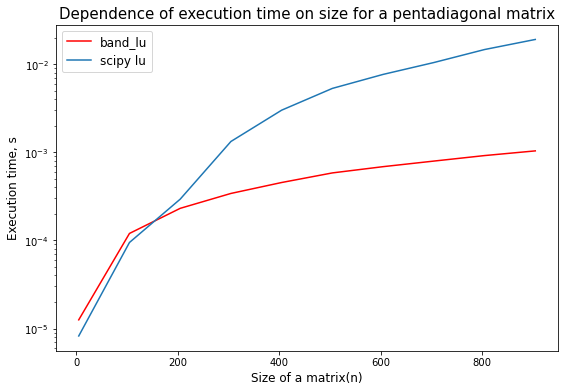

In [7]:
plt.rcParams["figure.figsize"] = (9,6)
line1, = plt.semilogy(range(5, 1000, 100), check_time1, 'r')
line2, = plt.semilogy(range(5, 1000, 100), check_time2)
plt.legend([line1, line2], ['band_lu', 'scipy lu'], fontsize=12)
plt.xlabel('Size of a matrix(n)', fontsize=12)
plt.ylabel('Execution time, s', fontsize=12)
plt.title('Dependence of execution time on size for a pentadiagonal matrix', fontsize=15);

My implenetation of an LU decomposition starts to perform better than scipy.linalg.lu for matrices with a size greater than 200. General asymptotic is way better. It happens because band_lu does not spare time for calculating all entires, but focus only on non-zero entries, as well only them matters. But this is possible only because this specific pattern is known beforehand.

### This section is devoted to testing Cholesky Factorization
#### An error appears for a matrix with size $n$ = 50 (for both my implementation and scipy function). I will investigate this.

In [8]:
from scipy.linalg import pascal

for n in [5, 10, 50]:
    L = cholesky(pascal(n))
    pasc_matr = pascal(n)
    #print(L, '\n\n', pascal_lower, '\n\n')
    
    if np.allclose(L @ L.T, pasc_matr) == True:
        print('Decomposition is correct for n =', n)

Decomposition is correct for n = 5
Decomposition is correct for n = 10


<ipython-input-1-3aa53fbf922b>:103: RuntimeWarning: invalid value encountered in sqrt
  L[j, j] = np.sqrt(A[0, 0])


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [9]:
# Can scipy handle this matrices?

from scipy.linalg import cholesky as chl

for n in [5, 10, 50]:
    L = chl(pascal(n), lower=True)
    pasc_matr = pascal(n)
    
    if np.allclose(L @ L.T, pasc_matr) == True:
        print('Decomposition is correct for n =', n)

Decomposition is correct for n = 5
Decomposition is correct for n = 10


LinAlgError: 30-th leading minor of the array is not positive definite

So, both scipy Cholesky decomposition and my Cholesky decomposition work properly for $n = 5$ and $n = 10$, but it can't handle $n=50$. Let's see why (for my implementation).

In [10]:
L = cholesky(pascal(50))

<ipython-input-1-3aa53fbf922b>:103: RuntimeWarning: invalid value encountered in sqrt
  L[j, j] = np.sqrt(A[0, 0])


In [11]:
L

array([[1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 1.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 2.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.000e+00, 4.700e+01, 1.081e+03, ...,       nan, 0.000e+00,
        0.000e+00],
       [1.000e+00, 4.800e+01, 1.128e+03, ...,       nan,       nan,
        0.000e+00],
       [1.000e+00, 4.900e+01, 1.176e+03, ...,       nan,       nan,
              nan]])

So, problem is in 'nan' as values in matrix. I know, that all the calculations of a new row in my implementation start with the diagonal element. Find a row of the frist 'nan' appearance and then check this element in corresponding Pascal matrix.

In [12]:
L[27:32, 27:32]

array([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [2.8000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [4.0600e+02, 3.3000e+01,        nan, 0.0000e+00, 0.0000e+00],
       [4.0600e+03, 4.3500e+02,        nan,        nan, 0.0000e+00],
       [3.1465e+04, 4.4840e+03,        nan,        nan,        nan]])

It all starts with the elemnt on the 30th row and 30th column.

In [13]:
pascal(50)[29, 29]

30067266499541040

In [14]:
# Here I try to extract information on RuntimeWarning.  

def cholesky_warning(A):
    n = A.shape[0]
    L = np.zeros((n, n))
    for j in range(0, n):
            L[j, j] = np.sqrt(A[0, 0])
            i = j + 1
            L[i:, j] = A[1:, 0] / L[j, j]
            if j == 28:
                print('The first element of (A[1:, 1:] - np.outer(L[i:, j], L[i:, j])) =', (A[1:, 1:] - np.outer(L[i:, j], L[i:, j]))[0, 0])

            A = A[1:, 1:] - np.outer(L[i:, j], L[i:, j])
    return L

L = cholesky_warning(pascal(50))

The first element of (A[1:, 1:] - np.outer(L[i:, j], L[i:, j])) = -239.0


<ipython-input-14-9ffaa1482f21>:7: RuntimeWarning: invalid value encountered in sqrt
  L[j, j] = np.sqrt(A[0, 0])


So, the problem is an extracting the root of a negative number, which leads to a 'nan'. On a step where the problem rises we subtract from an submatrix an outer product of its column which is divided by a square root of the previous element on the main diagonal (which is not in the submatrix). I can assume, that elements on the main diagonal in Pascal matrix has large values (lets call it $A_{i, j}$), but expression (which is the first entry of $l_{2,1}l_{2,1}^T$):

$$\bigg( \frac{A_{i, j-1}}{\sqrt{A_{i-1, j-1}}} \bigg)^ 2$$

has greater growth with growth of size of the matrix, hence, at some point it's defference become less than $0$, and square root is taken out of a negative value.

In [15]:
# Comparison of the result of my implementation with analytical expression in terms of some matrix norm of difference.

L_my = cholesky(pascal(25))
L_scipy = pascal(25, kind='lower')

print('Forbenius norm:', np.linalg.norm(L_my - L_scipy, 'fro'))
print('Spectrum norm:', np.linalg.norm(L_my - L_scipy, 2))
print('Implementation is good!')

Forbenius norm: 0.0
Spectrum norm: 0.0
Implementation is good!


#### Compare complexity for LU ($2n^3/3$) and Cholesky ($n^3/3$)
 - **LU**. To find each new entry below the pivot row requires one multiplication and one subtraction, hence, there is $n^2 - n$ multiplications and as many subtractions ($-n$ appears beacuse row 1 does not change). Matters only $n^2$ (for big enough $n$).
 
 The next step works with a matrix of lower size: $(n-1)$. To estimate this step you need $(n-1)^2$ multiplications and as many subtractions.
 
 To reach $U$ roughly you need $S = n^2 + (n-1)^2 +\dots+2^2 + 1^2$. This sum equals to $S = \frac{n(n+1/2)(n+1)}{3}$. With big enough $n$: $S = n^3/3$
 
 Hence, total complexity (**multiplications plus subtractions**) is $2n^3/3$
 
- **Cholesky**. (According to implemented approach). The first step requires: extracting the root, $(n-1)$ multiplications to obtain new vector ($l_{2,1}$), and $(n-1)$ multiplications and $(n-1)^2$ subtractions to get new matrix ($L_{2,2}$). In total, matters: $2n$ multiplications and $n^2$ subtractions.

 The next step works with a matrix of lower size: $(n-1)$. To estimate this step you need $2(n-1)$ multiplications and $(n-1)^2$ subtractions.

 So, there are two sums to estimate complexity:
 
 $$S = S_1 + S_2 \implies S = \big( n^2 + (n-1)^2 +\dots+2^2 + 1^2 \big) + 2\big(n + (n-1) +\dots+2 + 1 \big) \iff S = \frac{n(n+1/2)(n+1)}{3} + \frac{2n(n+1)}{2}, $$
 
 for big enough $n$:
 
 $$ S = \frac{n^3}{3} + n^2$$
 
 So, complexity for Cholesky decomposition is: $n^3/3$

### 2. Stability of LU (8 pts)

* (4 pts) Show, that for these  matrices $A$ and $B$ LU decomposition fails. Why does it happen?



$
A = \begin{pmatrix}
0 & 1 \\
2 & 3
\end{pmatrix}.$ 

$B = \begin{pmatrix}
1 & 1 & 0\\
1 & 1 & 2 \\
1 & 2 & 1
\end{pmatrix}.$ 

* (4 pts) In the LU decomposition, a pivot position is a position of the element that identifies the row and column that will be eliminated in the current step. For example, first pivot in LU is usually the left top element. What value of $c$ leads to zero in the second pivot position? What $c$ produces zero in the third pivot position? What modification of LU should we use in order to address the possible zeros in pivot position?

$A = \begin{pmatrix}
1 & c & 0\\
2 & 4 & 1 \\
3 & 5 & 1
\end{pmatrix}.$ 

### Solutions
#### 2.1 
LU decomposition for an arbitrary matrix is a Gaussian elimination which is not contain any row permutations.

If we do a gaussian elmimnation on $
A = \begin{pmatrix}
0 & 1 \\
2 & 3
\end{pmatrix}$ we initally face a problem of dividing by zero. To perform a Gaussian elimination we need to subtract from the second row elements of the first row times element under the pivot of this row divided by the  pivot. The very first pivot is equal to $0$ so we can't do a Gaussian elimination for exact this matrix.

For matrix $B$ we can do the first elimination: $ \begin{pmatrix}
1 & 1 & 0\\
1 & 1 & 2 \\
1 & 2 & 1
\end{pmatrix}; \begin{pmatrix}
1 & 1 & 0\\
0 & 0 & 2 \\
0 & 1 & 1
\end{pmatrix}$. But the second one faces the problem of dividing by zero again. To continue we have to perform a permutation (as in the case of matrix $A$) but it's not considered for the LU algorithm.

#### 2.2
Lets perform the first step of Gaussian elimination: $\begin{pmatrix}
1 & c & 0\\
2 & 4 & 1 \\
3 & 5 & 1
\end{pmatrix};  \begin{pmatrix}
1 & c & 0\\
0 & 4 - 2c & 1 \\
0 & 5 - 3c & 1
\end{pmatrix} $ So, $c = 2$ leads to a zero in the second pivot position.

Lets peform another one: $\begin{pmatrix}
1 & c & 0\\
0 & 4 - 2c & 1 \\
0 & 5 - 3c & 1
\end{pmatrix}; \begin{pmatrix}
1 & c & 0\\
0 & 4 - 2c & 1 \\
0 & 0 & 1 - \frac{5-3c}{4-2c}
\end{pmatrix} $

$c$ which leads to zero in the third pivot position: $1 - \frac{5-3c}{4-2c} = 0 \implies 4-2c -5 + 3c=0 \iff c = 1$

**Zero-pivot in the second position with $c=2$,  zero-pivot in the third position with $c=1$.**

To avoid problem of appearnce of a zero in a pivot position one need to perform the permutation. I assume, that the easiest way to do it is to perform a check before a next step of elimination. At this check one is searching for the biggest number at the possible pivot position for this column, than permute (if needed) the row with the biggest value and current row. All these permutations could be stored in a matrix $P$. A matrix of one permutation is an identity matrix with exchanged rows which numbers are the same as numbers of rows exchanged during elimination. The full matrix $P$ of permutations is a product of these matrices with one permutation.

### 3. Implementation of PLU decomposition (14 pts)

As you have noticed before, LU decomposition may fail. In order to make it stable, we can use LU decomposition with pivoting  (PLU).

We want to find such permutation matrix $P$ that LU decomposition of $PA$ exists

$$ PA = LU $$

- (7 pts) Implement efficiently PLU decomposition (without loops and with appropriate level of BLAS operations).  Also, pay attention to the way of permutation matrix storage.

- (4 pts ) Compare your function for computing PLU with built-in function on matrices of such type ```(mirror_diag = [1,2,1], n = 4)```. (Bandwidth and matrix size may vary). So, you can pass them as dense 2D NumPy array and do not tune your implementation to this special structure. Compare them in terms of running time (use ```%timeit``` magic) for range of dimensions to recover the asymptotic rate of time increasing and in terms of acuracy. We expect you plot the running time vs matrix dimension for built-in function and your implementation. So you should get the plot with two lines.
Consider additionally one of the pathological examples from above, where LU fails, but PLU has to work.


$$A = \begin{pmatrix}
0 & 0 & 1 & 1 \\
 0 &1 & 2 & 1  \\
 1 & 2 & 1  & 0\\
1 & 2  & 0 & 0  \\
\end{pmatrix}.$$


- (3 pts) Discuss the obtained results and explain how is it possible to accelerate computing the PLU factorization. 

NumPy or JAX are both ok in this problem, but please use the single library for all implementations. 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.linalg import lu

def p_l_u(A):
    n = A.shape[0]
    L = np.identity(n)
    P = np.identity(n)
    
    # You can't avoid this loop because permutations are to be saved.
    for j in range(0, n-1):
        i_max = np.argmax(np.abs(A)[j:, j]) + j                                   # I add j because np.argmax() strats indexing from the 0 in the given array (I gave a subvector of A)
        E = np.identity(n)
        
        if (i_max) != j:
            P[:, j], P[:, i_max] = np.copy(P[:, i_max]), np.copy(P[:, j])         # There I permute columns because we multiply by P from the right
            A[j, j:], A[i_max, j:] = np.copy(A[i_max, j:]), np.copy(A[j, j:])
                        
            if j > 0:
                L[j, :j], L[i_max, :j] = np.copy(L[i_max, :j]), np.copy(L[j, :j])

        L[j + 1:, j] = A[j + 1:, j] / A[j, j]
        E[j + 1:, j] = - A[j + 1:, j] / A[j, j] 
        
        # Matrix-by-vecotr products
        '''
        for k in range(j, n):
            A[j:, k] = np.einsum('ij,j', E[j:, j:], A[j:, k])
        '''
            
        # Vecotr-by-vector products
        '''
        Aa = 0
        for k in range(j, n):
            Aa = Aa + np.einsum('i,j->ij', E[j:, k], A[k, j:])
        A[j:, j:] = Aa
        '''
        
        # Matrix-by-matrix product
        
        #A = np.einsum('ik,kj->ij', E, A)
        A[j:, j:] = np.einsum('ik,kj->ij', E[j:, j:], A[j:, j:])
        
    return P, L, A



# A function to perform a check

def create_mirror_band(diag_broadcast, n):
    
    if len(diag_broadcast) == 3:
        a0 = [1] + [diag_broadcast[1]] * (n-1)
        a_up = [diag_broadcast[2]] * (n-1)
        a_lw = [diag_broadcast[0]] * (n-1)
                
        A = diags([a0, a_up, a_lw], offsets=[0, 1, -1]).toarray()
        
    elif len(diag_broadcast) == 5:
        a0 = [1] + [diag_broadcast[2]] * (n-1)
        a_up_1 = [diag_broadcast[3]] * (n-1)
        a_up_2 = [diag_broadcast[4]] * (n-2)
        a_lw_1 = [diag_broadcast[1]] * (n-1)
        a_lw_2 = [diag_broadcast[0]] * (n-2)
            
        A = diags([a_lw_2, a_lw_1, a0, a_up_1, a_up_2], offsets=[-2, -1, 0, 1, 2]).toarray()
        
    A = np.flip(A, axis=0)
    
    return A

**One of the pathological examples from above, where LU fails**

In [17]:
B = np.array([[1, 1, 0], [1, 1, 2], [1, 2, 1]])
B_c = B.copy()
print(B)
#P_sp, L_sp, U_sp = lu(B)
P_my, L_my, U_my = p_l_u(B)

if np.allclose(P_my @ L_my @ U_my, B_c) == True:
    print("PLU is correct.")

[[1 1 0]
 [1 1 2]
 [1 2 1]]
PLU is correct.


In [18]:
from scipy.linalg import lu
diag_broadcast = [1, 2, 1]
n = 4
A = create_mirror_band(diag_broadcast, n)
A_c = A.copy()
print(A)
#P_sp, L_sp, U_sp = lu(B)
P_my, L_my, U_my = p_l_u(A)

if np.allclose(P_my @ L_my @ U_my, A_c) == True:
    print("PLU is correct.")

[[0. 0. 1. 2.]
 [0. 1. 2. 1.]
 [1. 2. 1. 0.]
 [1. 1. 0. 0.]]
PLU is correct.


In [19]:
diag_broadcast = [3, 5, -8]
n = 5
A = create_mirror_band(diag_broadcast, n)
A_c = A.copy()
print(A)
P_sp, L_sp, U_sp = lu(A)
P_my, L_my, U_my = p_l_u(A)

if np.allclose(P_my @ L_my @ U_my, A_c) == True:
    print("My is correct.")
if np.allclose(P_sp @ L_sp @ U_sp, A_c) == True:
    print("Scipy is correct.")

[[ 0.  0.  0.  3.  5.]
 [ 0.  0.  3.  5. -8.]
 [ 0.  3.  5. -8.  0.]
 [ 3.  5. -8.  0.  0.]
 [ 1. -8.  0.  0.  0.]]
My is correct.
Scipy is correct.


In [20]:
A = np.random.rand(20, 20)
A_c = A.copy()
#print(A)
P_sp, L_sp, U_sp = lu(A)
P_my, L_my, U_my = p_l_u(A)

if np.allclose(P_my @ L_my @ U_my, A_c) == True:
    print("My is correct.")
if np.allclose(P_sp @ L_sp @ U_sp, A_c) == True:
    print("Scipy is correct.")

My is correct.
Scipy is correct.


In [21]:
diag_broadcast = [1, 2, 1]
check_t_my = []
check_t_scipy = []

for n in range(4, 100, 10):
    A = create_mirror_band(diag_broadcast, n)
    t_my = %timeit -o -q p_l_u(A)
    t_scipy = %timeit -o -q lu(A)
    check_t_my.append(t_my.best)
    check_t_scipy.append(t_scipy.best)

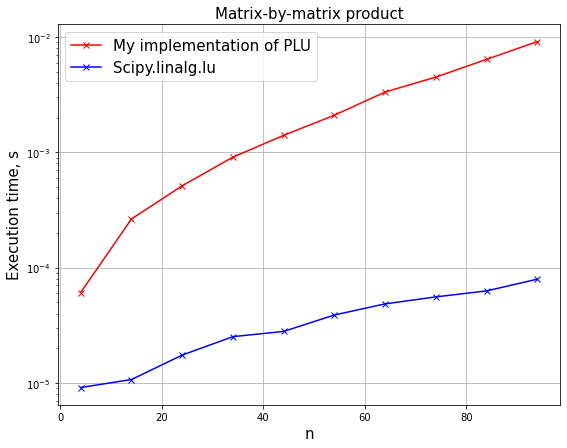

In [22]:
plt.rcParams['figure.figsize'] = (9,7)
plt.plot(range(4, 100, 10), check_t_my, 'r', marker='x', label='My implementation of PLU')
plt.plot(range(4, 100, 10), check_t_scipy, 'b', marker='x', label='Scipy.linalg.lu')
plt.xlabel('n', fontsize=15)
plt.ylabel('Execution time, s', fontsize=15)
plt.legend(fontsize=15)
plt.title('Matrix-by-matrix product', fontsize=15)
plt.yscale('log')
plt.grid(True)

Final implementation contains only $n-1$ matrix-by-matrix multiplications, so it's level-3 BLAS. Thinking on how it can be accelerated, I came up with shrinking the matrix $E$ and $A$ (beacuse upper part of $E$ is identity and upper part of $A$ does not change). Also, I tried approaches with matrix-by-vector and vector-by-vector products (see pictures below). These implemenations were worse (I assume because of an extra cycle).

![With matrix-by-vector products](https://drive.google.com/uc?export=view&id=1fUUXWtG26hCpMHFjWdnQIuF868o7MP-p)

![With vector-by-vector products](https://drive.google.com/uc?export=view&id=1i-aXuZoPuqHiRU3dbE8J9KcBr8FtH2Q0)

### 4. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <span style="color:red">Schur complement</span> of the block $A_{11}$.
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.
* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

### Solutions
#### 4.1
Elimination of augmented matrix: 

$ \left[\begin{array}{rr|r}
A_{11} & A_{12} & f_{1} \\
A_{21} & A_{22} & f_{2}
\end{array}\right] = \left[\begin{array}{rr|r}
A_{11} & A_{12} & f_{1} \\
0 & A_{22} - A_{11}^{-1} A_{12} & f_{2} - A_{11}^{-1} f_1
\end{array}\right] $

So, $S=A_{22} - A_{11}^{-1} A_{12}$ and $\hat{f_2} = f_{2} - A_{11}^{-1} f_1$ that $S = u_2 \hat{f_2}$. There $A_{11}$ has to be **non-singular**. Actually it's not a Schur complement. But in the task it's also clear set what we have to do, so I did: found such matrix $S$ and right-hand side $\hat{f_2}$.

#### 4.2
Schur complement of $A_{22}$ in $A$:$$ A / A_{22} = A_{11} - A_{12}A_{22}^{-1}A_{21} $$

Schur's formula ([tap me](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Flink.springer.com%2Fcontent%2Fpdf%2F10.1007%252F0-387-24273-2_2.pdf&clen=1007894&chunk=true)):

$$ \det(A / A_{22}) = \frac{\det(A)}{\det(A_{22})} $$

Let: $ Q = \begin{bmatrix} I & -B \\ A & X \end{bmatrix} $

Then Schur complement of $X$ in $Q$: $$ Q / X = I + BX^{-1}A $$

With Schur's formula: 

$$ \det(Q/X) = \frac{\det(Q)}{\det(X)} \iff \det(I + BX^{-1}A) = \frac{\det(X + AB)}{\det(X)} \iff \det(X + AB) = \det(X) \det(I + BX^{-1}A)$$

#### 4.3
Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

Let: $ Q = \begin{bmatrix} I_m & F \\ G & I_n  \end{bmatrix} $

Lets write Schur complements of $Q$ :

 - $ Q / I_n = I_m - F I_n^{-1} G \iff Q / I_n = I_m - F G $
 - $ Q / I_m = I_n - G I_m^{-1} F \iff Q / I_m = I_n - G F $

Then again use Schur's formula and equations above:
$$ \det(Q / I_n) = \frac{\det(Q)}{\det(I_n)} \iff \det(I_m - F G) = \frac{\det(Q)}{1} $$

$$ \det(Q / I_m) = \frac{\det(Q)}{\det(I_m)} \iff \det(I_n - G F) = \frac{\det(Q)}{1} $$

Hence: $ \det(I_m - F G) =\det(I_n - G F) $

## Problem 2 (eigenvalues)  (50 pts)

### 1. Theoretical tasks (15 pts)

* (2 pts) Prove that eigenvectors that correspond to distinct eigenvalues are linearly independent.

* (3 pts) $A$ is a matrix such that $a_{i,j} \ge 0$ and $\sum_{j}a_{i,j} = 1$ (sum of the elements in each row is 1). Prove that $A$ has an eigenvalue $\lambda=1$ and that any eigenvalue $\lambda_i$: $|\lambda_i| \le 1$.

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block (there is only one $\varepsilon$ - in the left lower corner):

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     0 & \lambda & 1 & & \\ 
     & 0 & \ddots & \ddots & \\ 
     & & 0 & \lambda & 1 \\ 
     \varepsilon & & & 0 & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

   Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

### Solutions
#### 1.1
Two eigenvectors and eigenvalues (both non-zero) of a matrix $A$: $Ax_1 = \lambda_1 x_1$ and $Ax_2 = \lambda_2 x_2$

Assume that they are linearly dependent, then: $c_1 x_1 + c_2 x_2 = 0$, where $c_1 \neq 0 \space \wedge \space c_2 \neq 0$.

$$A c_1 x_1 + A c_2 x_2 = A \cdot 0 \iff  c_1 \lambda_1 x_1 + c_2 \lambda_2 x_2 = 0 $$


So, $c_1 x_1 + c_2 x_2 = 0 \wedge c_1 \lambda_1 x_1 + c_2 \lambda_2 x_2 = 0 \implies $

$$\implies \begin{cases} x_1 = 0 \\ x_2 = 0 \end{cases} \vee \begin{cases} \lambda_1 = 0 \\ \lambda_2 = 0 \end{cases} \vee \begin{cases} c_1 = 0 \\ c_2 = 0 \end{cases},$$

which contradicts with inital assumption $\implies x_1 \wedge x_2$ are linearly independent. 

#### 1.2
 - The first part
 
$A$ is a matrix such that $a_{i,j} \ge 0$ and $\sum_{j}a_{i,j} = 1$ (sum of the elements in each row is 1).

Assume that $A$ has such $\lambda = 1$: $Ax = x,$ where $x$ is such eigenvector, that $x_1 = ... = x_2$. 
$$Ax = x \iff \begin{cases} x_1 = \sum_{j=1}^{n} a_{1,j} x_j \\ ... \\ x_n = \sum_{j=1}^{n} a_{n,j} x_j \end{cases} \iff \begin{cases} x_1 = x_1 \sum_{j=1}^{n} a_{1,j} \\ ... \\ x_n = x_n \sum_{j=1}^{n} a_{n,j} \end{cases} \iff \begin{cases} x_1 = x_1 \\ ... \\ x_n = x_n \end{cases} \iff True $$

So, $\lambda = 1 \wedge x$, such $x_1 = ... = x_2$ (for example, $x^T = [1, 1, ..., 1]$) are an eigenpair of $A$.

 - The second part
 
Arbitrary eigepair of $A$: $Ax = \lambda x$

The equality for an i-th row: $\lambda x_i = \sum_{j=1}^{n} a_{ij} x_j$

Choose usch i-th element: $|x_i| \ge |x_j|$ 

$$|\lambda| \cdot |x_i| = \bigg| \sum_{j=1}^{n} a_{ij} x_j \bigg| \le \sum_{j=1}^{n} a_{ij} |x_j| \le \sum_{j=1}^{n} a_{ij} |x_i| = 1 \cdot |x_i| \implies |\lambda| \cdot |x_i| \le 1 \cdot |x_i|$$

So, $|\lambda| \le 1$

#### 1.3
##### The first part
$A$ is Hermitian $\iff A = A^*$

$A$ is normal $\iff AA^* = A^*A$
<br><br>

 - normal is Hermitain $\implies \lambda \in \mathbb{R}$

$(Ax, x) = (\lambda x, x) = \lambda (x, x) = \lambda |x|^2$

At the same time: $ (Ax, x) = (x, A^*x) = (x, Ax) = \bar{\lambda} |x|^2 $

$$ \implies \lambda |x|^2 =  \bar{\lambda} |x|^2 \iff \lambda = \bar{\lambda} \iff \lambda \in \mathbb{R} $$

 - $\lambda \in \mathbb{R} \implies$ normal is Hermitain

$$(Ax, Ax) = x^* A^* A x \overset{A-normal}{\iff} (Ax, Ax) = x^* A A^* x \iff (Ax, Ax) = (A^*x)^* A^* x \iff (Ax, Ax) = (A^*x, A^*x) \iff A = A^*$$

Correct me if I am wrong, but we do not need condition $\lambda \in \mathbb{R}$ to prove that normal matrix is Hermitian.

##### The second part
$A$ is normal $\iff AA^* = A^*A$

$A$ is unitary $\iff AA^* = A^*A = I$

- normal is unitary $\implies \forall \lambda$ eigenvalue of $A$: $|\lambda|=1 $

$ (Ax, Ax) = x^*A^*Ax = x^*x=(x,x) $

At the same time: $(Ax, Ax) = \lambda^2 (x,x)$

$$ \implies \lambda^2 (x,x) = (x,x) \iff |\lambda| =1 $$


 - $\forall \lambda$ eigenvalue of $A$ and $A$ is normal: $|\lambda|=1 \implies$ matrix is unitary

$Ax= \lambda x $

At the same time: $(Ax)^* = \bar{\lambda} x^* \iff x^* A^* = \bar{\lambda} x^*$. Multiply first by the second from the left:

$$ (Ax, Ax) = x^*A^*Ax \iff (Ax, Ax) = \bar{\lambda}\lambda x^*x \overset{|\lambda|=1}{\iff}(Ax, Ax) = x^*x \iff (Ax, Ax) = (x, x) \implies $$

$\implies A - unitary$, because it does not change the norm.

#### 1.4
Calculate the determinant of via characterisitc polynomial:

$$ |J(\varepsilon) - \lambda'I| = 0 \iff
     \begin{vmatrix} 
     \lambda -\lambda' & 1 & & & 0 \\ 
     0 & \lambda -\lambda'& 1 & & \\ 
     & 0 & \ddots & \ddots & \\ 
     & & 0 & \lambda -\lambda' & 1 \\ 
     \varepsilon & & & 0 & \lambda -\lambda' 
    \end{vmatrix}_{n\times n} = 0 \iff \big( \lambda - \lambda' \big) \begin{vmatrix} 
     \lambda -\lambda' & 1 & & & 0 \\ 
     0 & \lambda -\lambda'& 1 & & \\ 
     & 0 & \ddots & \ddots & \\ 
     & & 0 & \lambda -\lambda' & 1 \\ 
     & & & 0 & \lambda -\lambda' 
    \end{vmatrix}_{n-1\times n-1} + \varepsilon \cdot (-1)^{n+1} \begin{vmatrix} 
     1 & & & 0 \\ 
     \lambda -\lambda'& 1 & & \\ 
     0 & \ddots & \ddots & \\ 
     & 0 & \lambda -\lambda' & 1 \\ 
     & & 0 & \lambda -\lambda' & 1 
    \end{vmatrix}_{n-1\times n-1} = 0 \iff$$

$$\iff (\lambda -\lambda')^n + (-1)^{n+1} \varepsilon = 0 \iff (-1)^n (\lambda' -\lambda)^n - (-1)^{n} \varepsilon = 0 \iff (\lambda' -\lambda)^n - \varepsilon = 0 \iff (\lambda' -\lambda)^n = \varepsilon $$

 - $\varepsilon \in \mathbb{R}$:
 
$$ \lambda' = \sqrt[n]{\varepsilon} + \lambda$$

 - $\varepsilon \in \mathbb{C}$:
 
$$ \lambda' = \sqrt[n]{r} e^{i \frac{\varphi}{n} + i \frac{2\pi}{n} k} + \lambda,$$

For $\varepsilon \in \mathbb{R}$: with $n \rightarrow \infty $ eigenvalues will $\lambda' \rightarrow \lambda + 1 $

For  $\varepsilon \in \mathbb{C}$: eigenvalues will oscilate ($n$ solutions with perturbation which is bad).

### 2. PageRank (35 pts)


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

In [23]:
import numpy as np
from scipy.sparse import issparse, diags
from scipy.sparse import lil_matrix

# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G):
    d_el = G.sum(axis=0)
    d_el[d_el == 0] = 1
    if issparse(G) == False:
        V = np.diag(1 / d_el, k=0)
        A = np.einsum('ij,jk', G, V)
    else:
        d_el = np.ravel(d_el)                          # Crucial part: otherwise d_el is treated as a matrix and can't be assigned anywhere.
        V = lil_matrix((d_el.shape[0],d_el.shape[0]))
        V = diags(1 / d_el)
        A = G @ V
    return A

In [24]:
# Checking a function

a = np.array([[0,1,0,0,1,0], [0,1,1,0,0,0], [0,0,0,0,0,1], [0,0,0,0,0,1]])
b = pagerank_matrix(a)
print(a)
b

[[0 1 0 0 1 0]
 [0 1 1 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]]


array([[0. , 0.5, 0. , 0. , 1. , 0. ],
       [0. , 0.5, 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5],
       [0. , 0. , 0. , 0. , 0. , 0.5]])

In [25]:
# Checking a function

from scipy.sparse import lil_matrix
a_lil = lil_matrix(a)
#print(a_lil)
b_lil = pagerank_matrix(a_lil)
print(b_lil)
print(b_lil.toarray())

  (0, 4)	1.0
  (0, 1)	0.5
  (1, 2)	1.0
  (1, 1)	0.5
  (2, 5)	0.5
  (3, 5)	0.5
[[0.  0.5 0.  0.  1.  0. ]
 [0.  0.5 1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.  0.5]]


* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have?


* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.

In [26]:
# Task about graph from the picture
# There are 5 nodes, hence, adjacency matrix P is n-by-n matrix. 
# Outgoing links for i-th page are in i-th row.

from numpy.linalg import eig

P = np.array([[0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [1, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 0]])
print('Adjacency matrix P\n', P, end='\n--------------------------\n')

A_pic = pagerank_matrix(P)
print('PageRank matrix A\n', A_pic, end='\n--------------------------\n')

# Largest eigienvalue of A_pic is \lambda = 1, as for every stochastic matrix

lmbd, vctr = eig(A_pic)
print(lmbd, '\n\n', vctr, end='\n--------------------------\n')

print('The largest eigenvalue of A\n', lmbd.max(), end='\n--------------------------\n')
print('There are two equal eigenvalues, so there are two multiplicity of them\n', vctr[:, 2], '\n\n', vctr[:, 3])

Adjacency matrix P
 [[0 1 0 0 0]
 [0 0 1 0 0]
 [1 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]]
--------------------------
PageRank matrix A
 [[0.  0.5 0.  0.  0. ]
 [0.  0.  1.  0.  0. ]
 [1.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  1.  0. ]]
--------------------------
[-0.5+0.5j -0.5-0.5j  1. +0.j   1. +0.j  -1. +0.j ] 

 [[ 0.35355339+0.35355339j  0.35355339-0.35355339j -0.33333333+0.j
   0.        +0.j          0.        +0.j        ]
 [-0.70710678+0.j         -0.70710678-0.j         -0.66666667+0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.35355339-0.35355339j  0.35355339+0.35355339j -0.66666667+0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        -0.j          0.        +0.j
   0.70710678+0.j         -0.70710678+0.j        ]
 [ 0.        +0.j          0.        -0.j          0.        +0.j
   0.70710678+0.j          0.70710678+0.j        ]]
--------------------------
The largest eigenvalue of A
 (1.0000000000000004+0j)
----

In [27]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])

def power_method(A, x0, num_iter): # 5 pts
    x = x0
    Ax = A @ x
    l = np.einsum('i,i->', Ax, x)
    norm = np.linalg.norm(Ax - x * l, ord=2)
    res = np.array([norm])
    
    for i in range(num_iter):
        x = A @ x
        x = x / np.linalg.norm(x, ord=2)
        Ax = A @ x
        l = np.einsum('i,i->', Ax, x)
        norm = np.linalg.norm(Ax - x * l, ord=2)
        res = np.append(res, norm)
    return x, l, res

In [28]:
# Test shows that everthing works just fine

test_power = np.array([[2, -1], [-1, 2]])
x0 = np.random.rand(2)
x_test, l_test, res_test = power_method(test_power, x0=x0, num_iter=30)
print(x_test)
print(l_test)
print(res_test)

[-0.70710678  0.70710678]
3.0
[8.67334261e-01 8.01439783e-01 3.25246369e-01 1.11100164e-01
 3.71355650e-02 1.23823176e-02 4.12757984e-03 1.37586516e-03
 4.58621912e-04 1.52873978e-04 5.09579928e-05 1.69859976e-05
 5.66199921e-06 1.88733307e-06 6.29111023e-07 2.09703674e-07
 6.99012250e-08 2.33004082e-08 7.76680274e-09 2.58893425e-09
 8.62978083e-10 2.87659152e-10 9.58861745e-11 3.19620582e-11
 1.06540194e-11 3.55154914e-12 1.18384971e-12 3.94407226e-13
 1.31574123e-13 4.39625888e-14 1.47622094e-14]


* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence. 

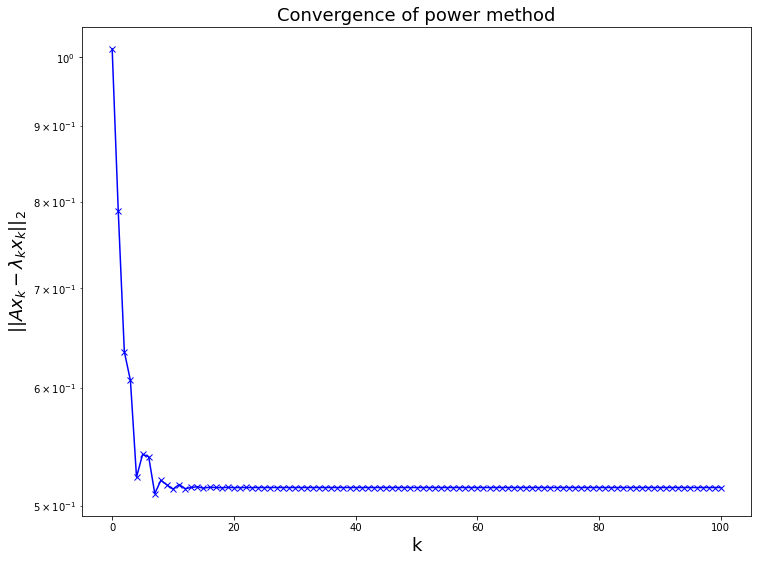

In [31]:
import numpy as np
import matplotlib.pyplot as plt

P = np.array([[0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [1, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 0]])
A = pagerank_matrix(P)
x0 = np.random.rand(A.shape[0])

_, _, res_graph = power_method(A, x0=x0, num_iter=100)
k = list(range(0, 101))

plt.rcParams['figure.figsize'] = (12,9)
plt.plot(k, res_graph, 'b', marker='x')
plt.title('Convergence of power method', fontsize=18)
plt.xlabel('k', fontsize=18)
plt.ylabel('$\|\|Ax_k - \lambda_k x_k\|\|_2$', fontsize=18)
plt.yscale('log');

The convergence rate of power method is $q = \frac{|\lambda_2|}{|\lambda_1|}$ and because this matrix has such two $\lambda_i = -\lambda_j$ there is no convergence.

* (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?

Eigenvalues of a new graph: [-0.5+0.5j -0.5-0.5j  1. +0.j  -0.5+0.j   1. +0.j ]



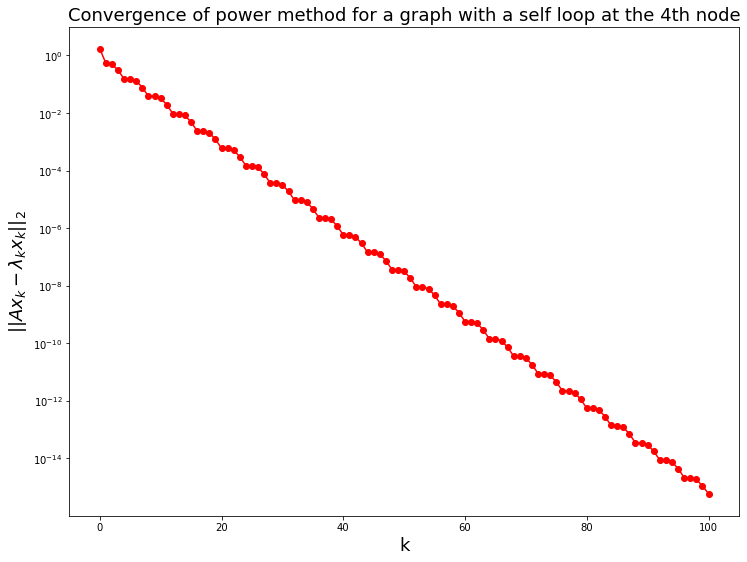

In [32]:
P = np.array([[0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [1, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 1]])
A = pagerank_matrix(P)
x0 = np.random.rand(A.shape[0])

_, _, res_graph = power_method(A, x0=x0, num_iter=100)
k = list(range(0, 101))

lmbd, _ = np.linalg.eig(A)
print('Eigenvalues of a new graph:', lmbd, end='\n\n')

plt.rcParams['figure.figsize'] = (12,9)
plt.plot(k, res_graph, 'r', marker='o')
plt.title('Convergence of power method for a graph with a self loop at the 4th node', fontsize=18)
plt.xlabel('k', fontsize=18)
plt.ylabel('$\|\|Ax_k - \lambda_k x_k\|\|_2$', fontsize=18)
plt.yscale('log');

Matrix of a graph with a self loop ate node 4 convergences because of new set of egienvalues (no $\lambda=-1$).

In [33]:
P = np.array([[0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [1, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 1]])
A = pagerank_matrix(P)
num_iter = 100

for i in range(1, 11):
    x0 = np.random.rand(A.shape[0])
    x, l, res = power_method(A, x0, num_iter)
    print('Initial guess {}. For eigenvalue l = {}, eigenvector: {}'.format(i, round(l, 1), x), end='\n\n')

Initial guess 1. For eigenvalue l = 1.0, eigenvector: [0.28682171 0.57364341 0.57364341 0.22785951 0.45571902]

Initial guess 2. For eigenvalue l = 1.0, eigenvector: [0.1841985  0.36839699 0.36839699 0.37272999 0.74545998]

Initial guess 3. For eigenvalue l = 1.0, eigenvector: [0.33111388 0.66222777 0.66222777 0.05152157 0.10304315]

Initial guess 4. For eigenvalue l = 1.0, eigenvector: [0.23735959 0.47471918 0.47471918 0.31398848 0.62797696]

Initial guess 5. For eigenvalue l = 1.0, eigenvector: [0.27156645 0.5431329  0.5431329  0.25933182 0.51866364]

Initial guess 6. For eigenvalue l = 1.0, eigenvector: [0.29836681 0.59673363 0.59673363 0.19939669 0.39879338]

Initial guess 7. For eigenvalue l = 1.0, eigenvector: [0.20469209 0.40938418 0.40938418 0.35296185 0.7059237 ]

Initial guess 8. For eigenvalue l = 1.0, eigenvector: [0.19830112 0.39660224 0.39660224 0.35946905 0.7189381 ]

Initial guess 9. For eigenvalue l = 1.0, eigenvector: [0.22778734 0.45557468 0.45557468 0.32650156 0.653

**I assume, that the convergence vary a little because for the new graph we have two equal by modulus egienvalues, which can lead us to one or another during convergence.**

In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.


* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.

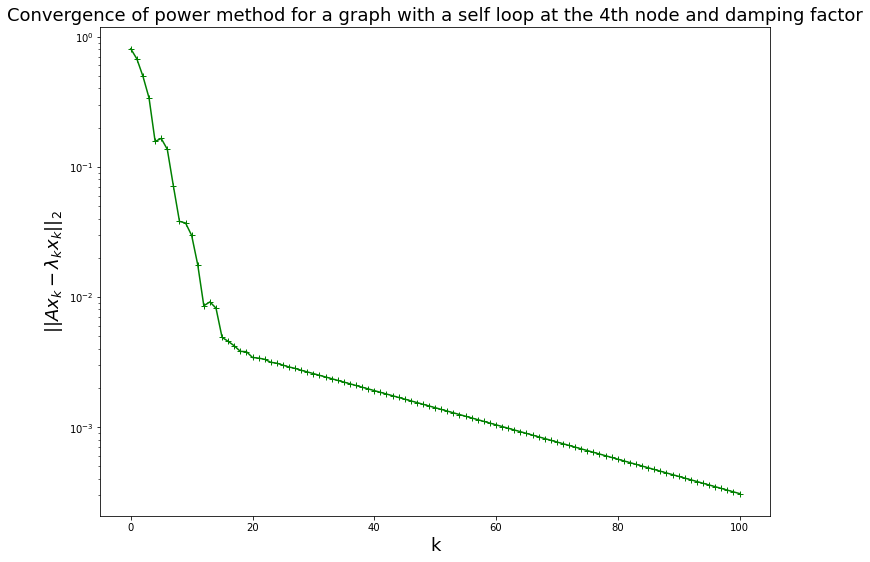

In [34]:
P = np.array([[0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [1, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 1]])
A = pagerank_matrix(P)
num_iter = 100
d = 0.97
ones_mat = np.ones((A.shape[0], A.shape[0]))
Ad = A * d + (1 - d) / A.shape[0] * ones_mat
x0 = np.random.rand(A.shape[0])

_, _, res_graph = power_method(Ad, x0=x0, num_iter=100)
k = list(range(0, 101))

plt.rcParams['figure.figsize'] = (12,9)
plt.plot(k, res_graph, 'g', marker='+')
plt.title('Convergence of power method for a graph with a self loop at the 4th node and damping factor', fontsize=18)
plt.xlabel('k', fontsize=18)
plt.ylabel('$\|\|Ax_k - \lambda_k x_k\|\|_2$', fontsize=18)
plt.yscale('log');

In [436]:
# A = sum(l_i * outer(x_i,x_i)), hence, the second largest eigenvalue will arise with A := A - l_1 * outer(x_1,x_1)

x1, l1, _ = power_method(Ad, x0, num_iter)
print('The first largest eigenvalue:', l)

_, l2, _ = power_method(Ad - l1 * np.outer(x1,x1), x0, num_iter)
print('The second largest eigenvalue:', l2)

The first largest eigenvalue: 0.9999999999999997
The second largest eigenvalue: 0.9699986097931894


Convergence is good. It looks like the second largest eigenvalue is equal to the first times damping factor. 

$d$ here is a raio of convergence of the power method which is $d = \big|\frac{\lambda_2}{\lambda_1} \big|$

In [439]:
from scipy.sparse import csr_matrix

# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x): # 2 pts
    x_sum = x.sum()
    y = (d * A @ x + (1 - d) / A.shape[0] * x_sum)
    return y

def direct_matvec(A, d, x):
    y = (A * d + (1 - d) / A.shape[0] * np.ones((A.shape[0], A.shape[0]))) @ x
    return y

In [440]:
# Check the function
P = np.array([[0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [1, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 1]])
A = pagerank_matrix(P)
x = np.array([1, 2, 6, -2, 2])
d = 0.97
print('Dense matrix result:', direct_matvec(A, d, x))

a_csr = csr_matrix(A)
print("Sparse matrix result:", pagerank_matvec(a_csr, d, x))

Dense matrix result: [ 1.024  5.874  1.994  1.024 -0.916]
Sparse matrix result: [ 1.024  5.874  1.994  1.024 -0.916]


In [441]:
from scipy.sparse import random

C_sparse = random(10000, 10000, density=0.000001, format='coo', random_state=11)
C_dense = C_sparse.toarray()
d = 0.97 
x = np.random.rand(10000)

print('Execution time for a pagerank_matvec:')
%timeit -o -q pagerank_matvec(C_sparse, d, x)

Execution time for a pagerank_matvec:


<TimeitResult : 59.1 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In [442]:
print('Execution time for a direct_matvec:')
%timeit -o -q direct_matvec(C_dense, d, x)

Execution time for a direct_matvec:


<TimeitResult : 1.67 s ± 461 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

The sparse implementation is way faster.

#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.
 
 
* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).


* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.


* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

In [443]:
from scipy.sparse import load_npz
import numpy as np
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors
G, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

In [444]:
print('Density of a G:', G.count_nonzero() / (G.shape[0] ** 2))

indx = []
sum_cite = G.sum(axis = 0)

for i in range(10):
    j = np.argmax(sum_cite)
    indx.append(j)
    sum_cite[0, j] = 0

print('Top 10 most cited authors:', authors[indx])

Density of a G: 4.4986518152305776e-05
Top 10 most cited authors: ['Scott Shenker' 'Andrew Zisserman' 'Hari Balakrishnan' 'Jiawei Han'
 'Anil K. Jain' 'Cordelia Schmid' 'Jitendra Malik' 'Ion Stoica'
 'David E. Culler' 'David G. Lowe']


In [445]:
print(G)
G[G != 0] = 1
print(G)

  (1, 20426)	1.0
  (1, 66077)	1.0
  (1, 424604)	1.0
  (1, 474477)	1.0
  (1, 505135)	1.0
  (1, 538619)	1.0
  (1, 559921)	1.0
  (1, 574939)	1.0
  (1, 663444)	1.0
  (1, 670953)	1.0
  (1, 1045256)	1.0
  (1, 1198032)	1.0
  (1, 1202457)	1.0
  (1, 1217776)	1.0
  (1, 1221065)	1.0
  (1, 1472173)	1.0
  (1, 1503772)	1.0
  (1, 1641678)	1.0
  (2, 2)	8.0
  (2, 17752)	1.0
  (2, 25486)	2.0
  (2, 26026)	2.0
  (2, 46006)	2.0
  (2, 56415)	1.0
  (2, 72249)	2.0
  :	:
  (1766531, 1421494)	3.0
  (1766531, 1505279)	1.0
  (1766531, 1687330)	2.0
  (1766531, 1725517)	1.0
  (1766531, 1726309)	1.0
  (1766534, 276602)	1.0
  (1766534, 713105)	1.0
  (1766542, 276602)	1.0
  (1766542, 713105)	1.0
  (1766543, 608313)	2.0
  (1766543, 874683)	1.0
  (1766543, 874694)	1.0
  (1766543, 969261)	2.0
  (1766543, 1759669)	1.0
  (1766544, 97343)	1.0
  (1766544, 228426)	1.0
  (1766544, 327176)	2.0
  (1766544, 496444)	2.0
  (1766544, 1015426)	2.0
  (1766544, 1059353)	1.0
  (1766544, 1204848)	1.0
  (1766544, 1304778)	1.0
  (1766544, 

In [446]:
A = pagerank_matrix(G)

In [448]:
# A is stochastic

A_sum = A.sum(axis=0)
for i in range(A_sum.shape[1]):
    if (round(A_sum[0, i], 1) != 1.0) & (round(A_sum[0, i], 1) != 0.0):
        print('A is not stochastic.\n', round(A_sum[0, i], 1))
        break

In [449]:
print(A_sum)

[[1. 1. 1. ... 0. 0. 0.]]


In [450]:
from scipy.sparse.linalg import LinearOperator
import numpy as np

d = 0.85
x = np.ones(A.shape[0])
L = LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))

x, l, res = power_method(L, x0=x, num_iter=100)

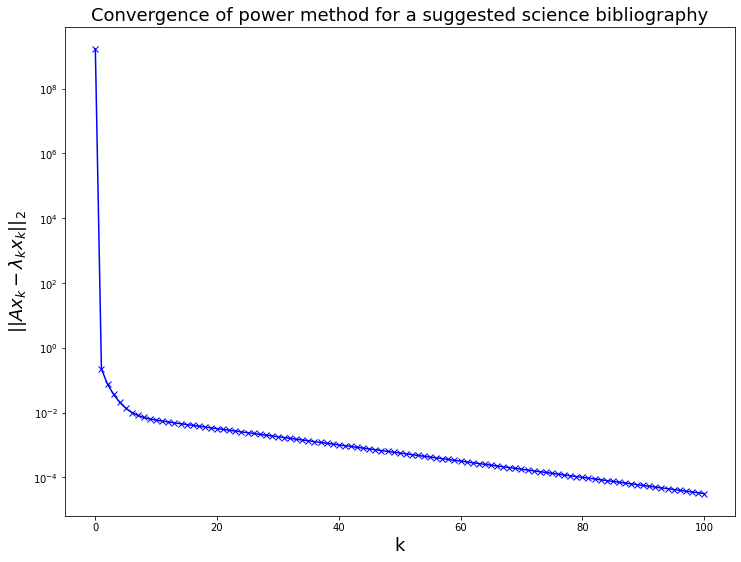

In [451]:
import matplotlib.pyplot as plt

k = list(range(0, 101))

plt.rcParams['figure.figsize'] = (12,9)
plt.plot(k, res, 'b', marker='x')
plt.title('Convergence of power method for a suggested science bibliography', fontsize=18)
plt.xlabel('k', fontsize=18)
plt.ylabel('$\|\|Ax_k - \lambda_k x_k\|\|_2$', fontsize=18)
plt.yscale('log');

Convergence is good.

In [452]:
print(x)

[4.09863277e-05 7.29067139e-05 5.51160271e-04 ... 4.31421715e-05
 4.09863277e-05 4.09863277e-05]


In [454]:
np.argsort(x)

array([      0,  753489,  753485, ..., 1626092, 1679237, 1625973],
      dtype=int64)

In [457]:
np.argsort(-x)

array([1625973, 1679237, 1626092, ...,  987459,  987455, 1766546],
      dtype=int64)

In [458]:
x_sort_dsc = np.argsort(-x)              # Sort is descending order

print('Top 10 most cited authors:', authors[x_sort_dsc[:10]])

Top 10 most cited authors: ['Wei Wang' 'Yang Liu' 'Wei Zhang' 'Wei Li' 'Lei Wang'
 'Athanasios V. Vasilakos' 'Lei Zhang' 'Jun Zhang' 'Jun Wang' 'Li Li']


A new set of the top 10 most cited authors is changed completely.

## Problem 3. QR algorithm (33 pts)

* Implement QR-algorithm without shifts. Prototype of the function is given below

In [35]:
import numpy as np
from scipy.linalg import norm
# INPUT: 
# A_init - square matrix, 
# num_iter - number of iterations for QR algorithm
# OUTPUT: 
# Ak - transformed matrix A_init given by QR algorithm, 
# convergence - numpy array of shape (num_iter, ), 
# where we store the maximal number from the Chebyshev norm 
# of triangular part of the Ak for every iteration

def qr_algorithm(A_init, num_iter): # 3 pts
    Ak = A_init
    convergence = np.array([])
    norm = 0
    
    for k in range(num_iter):
        Q_k, R_k = np.linalg.qr(Ak, mode='complete')
        Ak = R_k @ Q_k
        norm = np.amax(np.abs(np.tril(Ak, k=-1)))         # Chebyshev norm is just a maximum entry of a matrix
        convergence = np.append(convergence, norm)
    
    return Ak, convergence

#### Symmetric case (3 pts)
- Create symmetric tridiagonal $11 \times 11$ matrix with elements $-1, 2, -1$ on sub-, main- and upper diagonal respectively without using loops.
- Run $400$ iterations of the QR algorithm for this matrix.
- Plot the output matrix with function ```plt.spy(Ak, precision=1e-7)```.
- Plot convergence of QR-algorithm.

In [36]:
from scipy.sparse import diags

def create_symm_qr(diag_band, n):
    a0 = [diag_band[1]] * n
    a_up = [diag_band[2]] * (n-1)
    a_lw = [diag_band[0]] * (n-1)

    A = diags([a0, a_up, a_lw], offsets=[0, 1, -1]).toarray()
    return A

In [37]:
diag_band = [-1, 2, -1]
n = 11
num_iter = 400
B = create_symm_qr(diag_band, n)
Bk, cnvrg = qr_algorithm(B, num_iter)

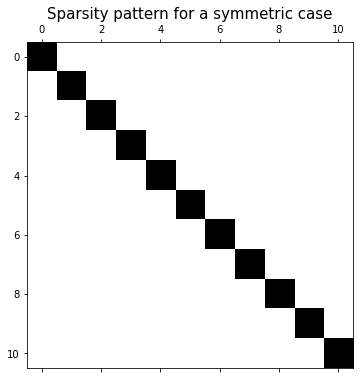

In [38]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (9, 6)
plt.spy(Bk, precision=1e-7)
plt.title('Sparsity pattern for a symmetric case', fontsize=15);

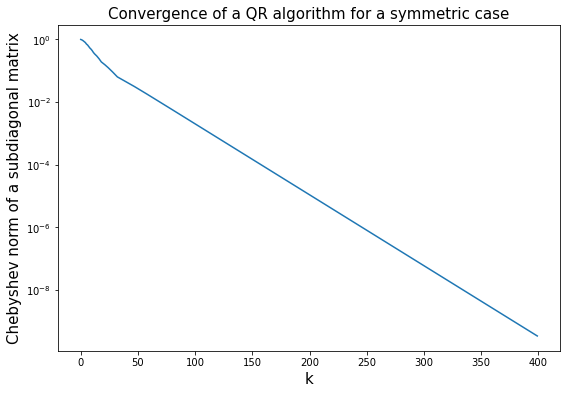

In [39]:
plt.rcParams['figure.figsize'] = (9, 6)
plt.plot(range(num_iter), cnvrg)
plt.title('Convergence of a QR algorithm for a symmetric case', fontsize=15)
plt.ylabel('Chebyshev norm of a subdiagonal matrix', fontsize=15)
plt.xlabel('k', fontsize=15)
plt.yscale('log');

Convergence is good.

#### Nonsymmetric case (5 pts)

- Create nonsymmetric tridiagonal $11 \times 11$ matrix with elements $5, 3, -2$ on sub-, main- and upper diagonal respectively without using loops.
- Run $250$ iterations of the QR algorithm for this matrix.
- Plot the result matrix with function ```plt.spy(Ak, precision=1e-7)```. Is this matrix lower triangular? How does this correspond to the claim about convergence of the QR algorithm?

In [40]:
diag_band_2 = [5, 3, -2]
n = 11
num_iter_2 = 250
C = create_symm_qr(diag_band_2, n)
Ck, cnvrg_2 = qr_algorithm(C, num_iter_2)

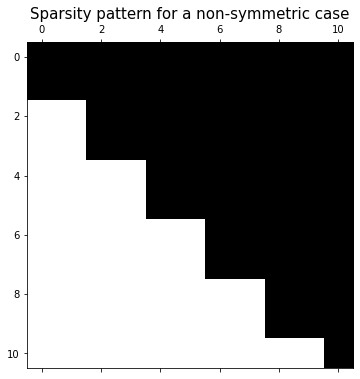

In [41]:
plt.rcParams['figure.figsize'] = (9, 6)
plt.spy(Ck, precision=1e-7)
plt.title('Sparsity pattern for a non-symmetric case', fontsize=15);

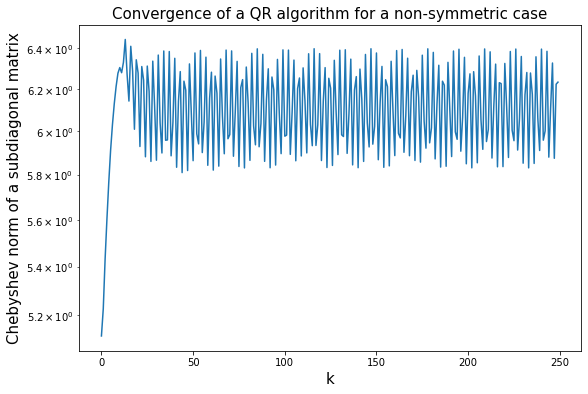

In [42]:
plt.rcParams['figure.figsize'] = (9, 6)
plt.plot(range(num_iter_2), cnvrg_2)
plt.title('Convergence of a QR algorithm for a non-symmetric case', fontsize=15)
plt.ylabel('Chebyshev norm of a subdiagonal matrix', fontsize=15)
plt.xlabel('k', fontsize=15)
plt.yscale('log');

For symmetric case QR algorithm convergence to a diagonal matrix. For a non-symmetric it convergences to an block upper-triangular.

### QR algorithms with Rayleigh Quotient shift (10 pts)

In the lectures the Rayleigh Quotient shift was introduced to speed up convergence of power method. Here we ask you to generalize this approach to construct the shifts in QR algorithm.

- How to compute the Rayleigh Quotient shift in QR algorithm fast? Provide formulas and explanations how they can be simplified.
- Implement explicit QR algorithm with Rayleigh Quotient shift. Please do not worry about implicit orthogonalization, we want to compare convergence only in terms of iterations.
- Test your implementation in the symmetric case. Plot the convergence of QR algorithm with and without shift. Choose the dimension $n \sim 100 $ for more representative results. 
- How the convergence of the shifted algorithm compares to the simple QR? Why? 

#### The Shifted QR algorithm:
$$ A_{k-1} - \mu_{k}I = Q_k R_k, \tag{1}$$

$$ A_{k} = R_k Q_k + \mu_{k}I \tag{2}$$

Lets derive $R_k$ from $(1)$ and pu it to $(2)$: $$ R_k = Q_k^T \big(A_{k-1} - \mu_{k}I \big); $$

$$ A_{k} = Q_k^T \big(A_{k-1} - \mu_{k}I \big) Q_k + \mu_{k}I \iff A_{k} = Q_k^T A_{k-1} Q_k- Q_k^T \mu_{k}I Q_k + \mu_{k}I, $$

where $ Q_k^T \mu_{k}I Q_k = \mu_{k}I $, so:

$$ A_{k} = Q_k^T A_{k-1} Q_k \tag{3}$$

I will use $(3)$ to compute $A_k$.

Then there is: $$ A_k = (\bar{Q_k})^T A \bar{Q_k}, $$

where $\bar{Q_k} = \prod_{i=1}^{k} Q_i$.

And:

$$ (A - \mu_k I)(A - \mu_{k-1} I)...(A - \mu_1 I) = \bar{Q}_k \bar{R}_k $$

First attempt: to use a Rayleigh Quotient as the shift.

#### Rayleigh Quotient: $$ R_A(x) = \frac{(Ax,x)}{(x,x)} $$

So, I need to choose a vector $x$ somehow. 

$$ \mu_k = \frac{(q_k^{(m)})^T A q_k^{(m)}}{(q_k^{(m)})^T q_k^{(m)}}, $$

where $q_k^{(m)}$ is the $m$-th (the last) column-vector of $Q_k$. Because columns of $Q_k$ is orthogonal: $$ \mu_k = (q_k^{(m)})^T A q_k^{(m)}$$

Lets derive the value for $\mu$:

$$ \mu_k = (q_k^{(m)})^T A q_k^{(m)} = (e_k^{(m)})^T \big(\bar{Q_k} \big)^T A \bar{Q_k} e_k^{(m)} = (e_k^{(m)})^T A_k e_k^{(m)} = (A_k)_{m,m} \implies $$

$$ \implies \mu_k = (A_k)_{m,m}, $$

where $(A_k)_{m,m}$ is an entry of $A_k$ on position $m,m$.

#### Hence, new interation looks as follows:

$$\mu_k = (A_{k-1})_{m,m}$$
$$A_{k-1} - \mu_{k}I = Q_k R_k,$$
$$A_{k} = Q_k^T A_{k-1} Q_k,$$

References: [chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fdspace.mit.edu%2Fbitstream%2Fhandle%2F1721.1%2F75282%2F18-335j-fall-2006%2Fcontents%2Flecture-notes%2Flec16.pdf&clen=67872),

[chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=http%3A%2F%2Fwww.math.iit.edu%2F~fass%2F477577_Chapter_11.pdf&clen=178593&chunk=true).

Also, it is a bad idea to wait for a zero value in an off-diagonal entries. So, if its values is small enough I will set it as 0 and proceed with matrix $A_k[:-1, :-1]$. See clarification [there](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fwww.math.kth.se%2Fna%2FSF2524%2Fmatber15%2Fqrmethod.pdf&clen=262335&chunk=true).

In [43]:
def qr_algorithm_reileigh(A_init, num_iter):
    convergence = np.array([])
    norm = 0
    Ak = A_init
    tol = 1e-5
    eigen_values = []
    
    for i in range(num_iter):
        if Ak.shape[0] != 1:
            #while Ak[-1, -2] != 0:
            #print(Ak.shape)

            shift = np.diag([Ak[-1, -1]] * Ak.shape[0])
            Q_k, R_k = np.linalg.qr(Ak - shift, mode='complete')
            Ak = Q_k.T @ Ak @ Q_k
            norm = np.amax(np.abs(np.tril(Ak, k=-1)))         # Chebyshev norm is just a maximum entry of a matrix
            convergence = np.append(convergence, norm)

            if (np.abs(Ak[-1, -2]) < tol) | (np.abs(Ak[-2, -1]) < tol):
                eigen_values.append(Ak[-1, -1])
                Ak = Ak[:-1, :-1]
        else:
            eigen_values.append(Ak[0,0])
            break
            
    if Ak.shape[0] == 1:
        A_init = np.diag(eigen_values)
    else:
        A_init[:Ak.shape[0], :Ak.shape[0]] = Ak
        A_init[Ak.shape[0]:, Ak.shape[0]:] = np.diag(eigen_values)
    
    return A_init, convergence, eigen_values

In [44]:
# Comparison of convergence with and without shifts for a symmetric case.

diag_band = [-1, 2, -1]
n_rq = 10
num_iter_rq = 100

Arq = create_symm_qr(diag_band, n_rq)
_, conv = qr_algorithm(Arq, num_iter_rq)
_, conv_shift, eig_v = qr_algorithm_reileigh(Arq, num_iter_rq)

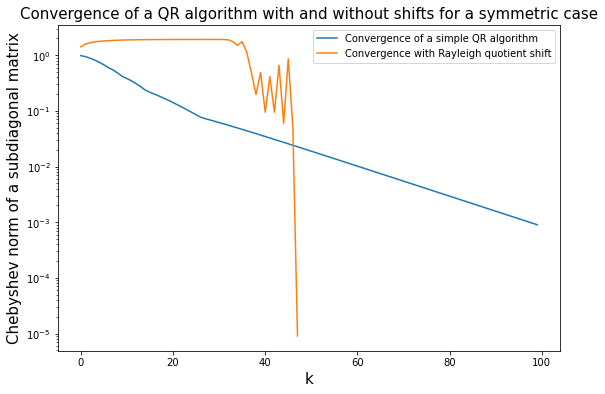

In [45]:
plt.rcParams['figure.figsize'] = (9, 6)
plt.plot(range(num_iter_rq), conv, label='Convergence of a simple QR algorithm')
plt.plot(range(conv_shift.shape[0]), conv_shift, label='Convergence with Rayleigh quotient shift')
plt.title('Convergence of a QR algorithm with and without shifts for a symmetric case', fontsize=15)
plt.ylabel('Chebyshev norm of a subdiagonal matrix', fontsize=15)
plt.legend(fontsize= 10)
plt.xlabel('k', fontsize=15);
plt.yscale('log');

In [46]:
# Check for a small matrix - eigenvalues are correct

from scipy.linalg import eig
print(eig_v)
print(eig(Arq)[0])

[2.284629676449227, 1.7153703235507702, 2.830830026003771, 1.1691699739962276, 3.3097214678905735, 0.6902785321102352, 3.6825070656570382, 0.3174929343470144, 3.918985947202534, 0.08101405279260365]
[3.91898595+0.j 3.68250707+0.j 3.30972147+0.j 2.83083003+0.j
 2.28462968+0.j 1.71537032+0.j 0.08101405+0.j 0.31749293+0.j
 0.69027853+0.j 1.16916997+0.j]


In [47]:
# Comparison of convergence with and without shifts for a symmetric case.

diag_band = [-1, 2, -1]
n_rq = 200
num_iter_rq = 5000

Arq = create_symm_qr(diag_band, n_rq)
_, conv = qr_algorithm(Arq, num_iter_rq)
_, conv_shift, _ = qr_algorithm_reileigh(Arq, num_iter_rq)

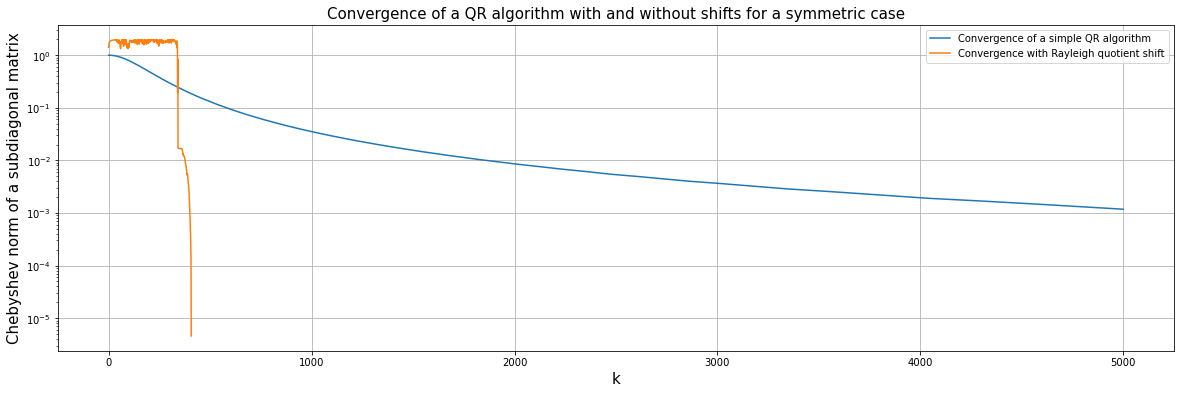

In [48]:
plt.rcParams['figure.figsize'] = (20, 6)
plt.plot(range(num_iter_rq), conv, label='Convergence of a simple QR algorithm')
plt.plot(range(conv_shift.shape[0]), conv_shift, label='Convergence with Rayleigh quotient shift')
plt.title('Convergence of a QR algorithm with and without shifts for a symmetric case', fontsize=15)
plt.ylabel('Chebyshev norm of a subdiagonal matrix', fontsize=15)
plt.legend(fontsize= 10)
plt.grid(True)
plt.xlabel('k', fontsize=15);
plt.yscale('log');

The convergence of shifted QR is way better: for a tridiagonal matrix with size $n=200$ it converges in $~420$ iterations, but for a simple QR on the $5000$th iterations it's still not done completely. Convergence depends of the ration of eigenvalues: $\lambda_j / \lambda_{j-1}$. And when we introduce shift $\mu$ it becomes: $(\lambda_j -\mu) / (\lambda_{j-1} - \mu)$, hence, converges faster.

- Try QR with Rayleigh Quotient shift for a simple matrix $A = \begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}$. Does anything change from iteration to iteration? Does shift affect convergence here? Why?

In [49]:
A1 = np.array([[0, 1], [1, 0]])
n1 = 2
n_iter1 = 100
_, conv1 = qr_algorithm(A1, n_iter1)
_, conv_shift1, _ = qr_algorithm_reileigh(A1, n_iter1)

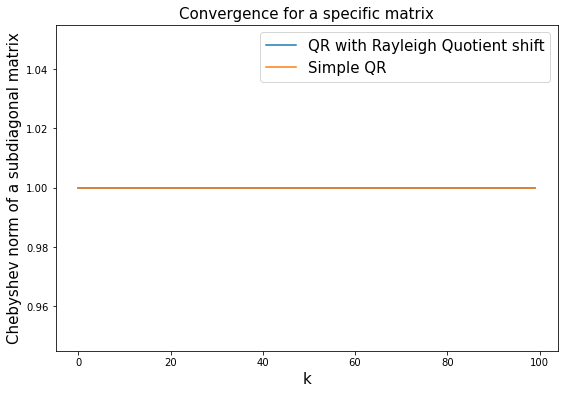

In [50]:
plt.rcParams['figure.figsize'] = (9, 6)
plt.plot(range(n_iter1), conv_shift1, label='QR with Rayleigh Quotient shift')
plt.plot(range(n_iter1), conv1, label='Simple QR')
plt.title('Convergence for a specific matrix', fontsize=15)
plt.ylabel('Chebyshev norm of a subdiagonal matrix', fontsize=15)
plt.xlabel('k', fontsize=15);
plt.legend(fontsize=15);

Nothing changes from iteration to iteration. Shift actually does not affect a convergence. It happens because Rayleigh Quotient cannot handle matrices with not unique egienvalues.

### QR with Wilkinson shift  (15 pts)

To solve the problem that appears in the last example, we can use the Wilkinson shift:

$$\mu = a_m - \frac {sign(\delta) b^2_{m-1}} {(|\delta| + \sqrt{\delta^2 + b^2_{m-1}} )},$$

where $\delta = \frac{(a_{m-1} - a_m)}{2}$. If $\delta = 0$, then instead of $sign(\delta)$ you have to choose $1$ or $-1$ arbitrary.
The numbers $a_m, b_{m-1}, a_{m-1}$ are taken from matrix $B$:

$$
    B = 
    \begin{bmatrix} 
     a_{m-1} & b_{m-1} \\ 
     b_{m-1} & a_m \\ 
    \end{bmatrix},
$$  
which is a lower right bottom submatrix of $A^{(k)}$. Here $k$ is an iteration counter in QR algorithm.

- Compare convergence in the symmetric cases: 
    - distinctive eigenvalues
    - two coincident eigenvalues
    - maximum and minimum eigenvalues with the same absolute value
Choose the dimension $n \sim 100 $ for more representative results.
What do you observe? 

In [51]:
def qr_algorithm_wilkinson(A_init, num_iter):
    convergence = np.array([])
    norm = 0
    Ak = A_init
    tol = 1e-5
    eigen_values = []
    
    for i in range(num_iter):
        if Ak.shape[0] != 1:
            dlt = (Ak[-2, -2] - Ak[-1, -1]) / 2
            if dlt != 0:
                shift = Ak[-1, -1] - (np.sign(dlt) * Ak[-1, -2] ** 2) / (np.abs(dlt) + np.sqrt(dlt ** 2 + Ak[-1, -2] ** 2))
            else:
                shift = Ak[-1, -1] - Ak[-1, -2] ** 2 / np.abs(Ak[-1, -2]) 
            

            shift = np.diag([shift] * Ak.shape[0])
            Q_k, R_k = np.linalg.qr(Ak - shift, mode='complete')
            Ak = Q_k.T @ Ak @ Q_k
            norm = np.amax(np.abs(np.tril(Ak, k=-1)))         # Chebyshev norm is just a maximum entry of a matrix
            convergence = np.append(convergence, norm)

            if (np.abs(Ak[-1, -2]) < tol) | (np.abs(Ak[-2, -1]) < tol):
                eigen_values.append(Ak[-1, -1])
                Ak = Ak[:-1, :-1]
        else:
            eigen_values.append(Ak[0,0])
            break
            
    if Ak.shape[0] == 1:
        A_init = np.diag(eigen_values)
    else:
        A_init[:Ak.shape[0], :Ak.shape[0]] = Ak
        A_init[Ak.shape[0]:, Ak.shape[0]:] = np.diag(eigen_values)
    
    return A_init, convergence, eigen_values
    
    
    for k in range(num_iter):
        dlt = (Ak[-2, -2] - Ak[-1, -1]) / 2
        if dlt != 0:
            shift = Ak[-1, -1] - (np.sign(dlt) * Ak[-1, -2] ** 2) / (np.abs(dlt) + np.sqrt(dlt ** 2 + Ak[-1, -2] ** 2))
        else:
            shift = Ak[-1, -1] - Ak[-1, -2] ** 2 / np.abs(Ak[-1, -2]) 
        shift = shift * np.identity(n)
        Q_k, R_k = np.linalg.qr(Ak - shift, mode='complete')
        Ak = Q_k.T @ Ak @ Q_k
        norm = np.amax(np.abs(np.tril(Ak, k=-1)))         # Chebyshev norm is just a maximum entry of a matrix
        convergence = np.append(convergence, norm)
    
    return Ak, convergence

In [52]:
# Create a random matrix with specific diagonal elements and change it into upper Hessenberg form
from scipy.linalg import hessenberg

def get_symm(n, D):
    B = np.random.rand(n, n)
    np.fill_diagonal(B, D)
    T = np.tril(B)
    A = (T + np.einsum('ji', T)) / 2
    A = hessenberg(A)
    return A

**Check with distinct eigenvalues**

In [53]:
# Check with distinct eigenvalues
n = 200
D = np.random.rand(n)

while len(np.unique(D)) != len(D):
    D = np.random.rand(n)
D = np.diag(D)

In [54]:
A1 = get_symm(n, D)
num_iter1 = 500

_, conv1 = qr_algorithm(A1, num_iter1)
_, conv1_shift_r, _ = qr_algorithm_reileigh(A1, num_iter1)
_, conv1_shift_w, _ = qr_algorithm_wilkinson(A1, num_iter1)

In [55]:
from scipy.linalg import eig

if np.unique(eig(A1)[0]).shape[0] == A1.shape[0]:
    print('All eigenvalues are distinct.')

All eigenvalues are distinct.


In [56]:
if np.allclose(A1, A1.T):
    print('A matrix is symmetric.')

A matrix is symmetric.


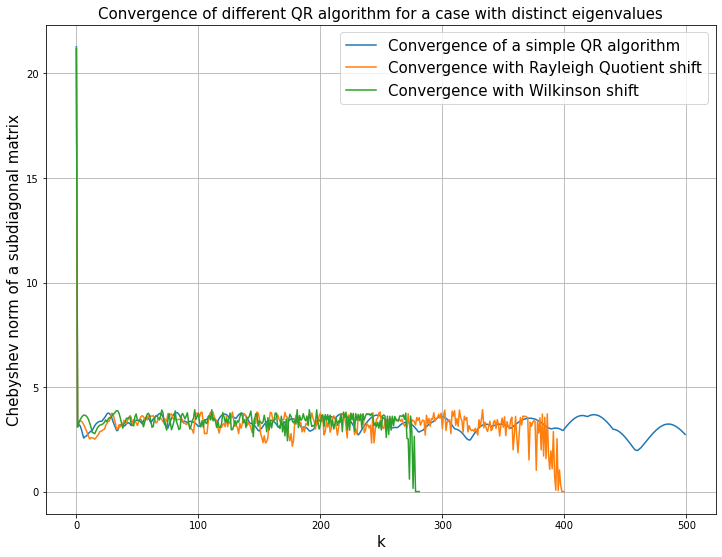

In [57]:
plt.rcParams['figure.figsize'] = (12, 9)
plt.plot(range(num_iter1), conv1, label='Convergence of a simple QR algorithm')
plt.plot(range(conv1_shift_r.shape[0]), conv1_shift_r, label='Convergence with Rayleigh Quotient shift')
plt.plot(range(conv1_shift_w.shape[0]), conv1_shift_w, label='Convergence with Wilkinson shift')

plt.title('Convergence of different QR algorithm for a case with distinct eigenvalues', fontsize=15)
plt.ylabel('Chebyshev norm of a subdiagonal matrix', fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('k', fontsize=15);
plt.grid(True)
#plt.yscale('log')

**Check with two coincident eigenvalues**

In [58]:
# Check with two coincident eigenvalues
from scipy.linalg import schur

n = 200
D2 = np.random.rand(n)

while len(np.unique(D2)) != len(D2):
    D2 = np.random.rand(n)
D2 = np.diag(D2)

A2 = get_symm(n, D2)
num_iter2 = 500

T, Z = schur(A2)
print(T[1, 1])
print(T[0, 0])
T[1, 1] = T[0, 0]
A2 = Z @ T @ Z.conj().T
print(T[1, 1])

#There are two coincident eigenvalues
print(np.flip(np.unique(eig(A2)[0], return_counts=True)[0])[:2])
print('\nThere is two coincident eigenvalues.')

3.815283683717267
49.846660270027144
49.846660270027144
[49.84666027+0.j 49.84666027+0.j]

There is two coincident eigenvalues.


In [59]:
if np.allclose(A2, A2.T):
    print('A matrix is symmetric.')

A matrix is symmetric.


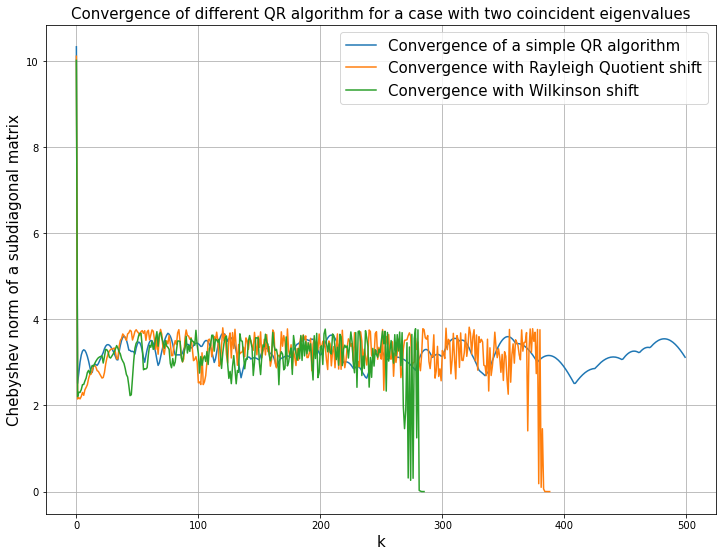

In [60]:
_, conv2 = qr_algorithm(A2, num_iter2)
_, conv2_shift_r, _ = qr_algorithm_reileigh(A2, num_iter2)
_, conv2_shift_w, _ = qr_algorithm_wilkinson(A2, num_iter2)

plt.rcParams['figure.figsize'] = (12, 9)
plt.plot(range(num_iter2), conv2, label='Convergence of a simple QR algorithm')
plt.plot(range(conv2_shift_r.shape[0]), conv2_shift_r, label='Convergence with Rayleigh Quotient shift')
plt.plot(range(conv2_shift_w.shape[0]), conv2_shift_w, label='Convergence with Wilkinson shift')

plt.title('Convergence of different QR algorithm for a case with two coincident eigenvalues', fontsize=15)
plt.ylabel('Chebyshev norm of a subdiagonal matrix', fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('k', fontsize=15);
plt.grid(True)
#plt.yscale('log')

**Check with maximum and minimum eigenvalues with the same absolute value**

In [61]:
# Check with maximum and minimum eigenvalues with the same absolute value
from scipy.linalg import schur

n = 200
D3 = np.random.rand(n)

while len(np.unique(D3)) != len(D3):
    D3 = np.random.rand(n)
D3 = np.diag(D3)

A3 = get_symm(n, D3)
num_iter3 = 500

T3, Z3 = schur(A3)
T_diag = np.diag(T3)

val_max = np.amax(np.abs(T_diag))
i_max = np.argmax(np.abs(T_diag))
print(T_diag[i_max])
print(val_max)
T_diag_copy = np.copy(T_diag)
T_diag_copy[i_max] = val_max

if (i_max + 1) < T_diag_copy.shape[0]: 
    T_diag_copy[i_max + 1] = - val_max
else:
    T_diag_copy[i_max - 1] = - val_max

print(np.amax(T_diag_copy))
print(np.amin(T_diag_copy))
np.fill_diagonal(T3, T_diag_copy)
A3 = Z3 @ T3 @ Z3.conj().T

#There are two coincident eigenvalues
print(np.unique(eig(A3)[0], return_counts=True)[0][0], np.unique(eig(A3)[0], return_counts=True)[0][-1])
print('\nThere are maximum and minimum eigenvalues with the same absolute value.')

49.90732075164244
49.90732075164244
49.90732075164244
-49.90732075164244
(-49.90732075164243+0j) (49.90732075164253+0j)

There are maximum and minimum eigenvalues with the same absolute value.


In [62]:
if np.allclose(A3, A3.T):
    print('A matrix is symmetric.')

A matrix is symmetric.


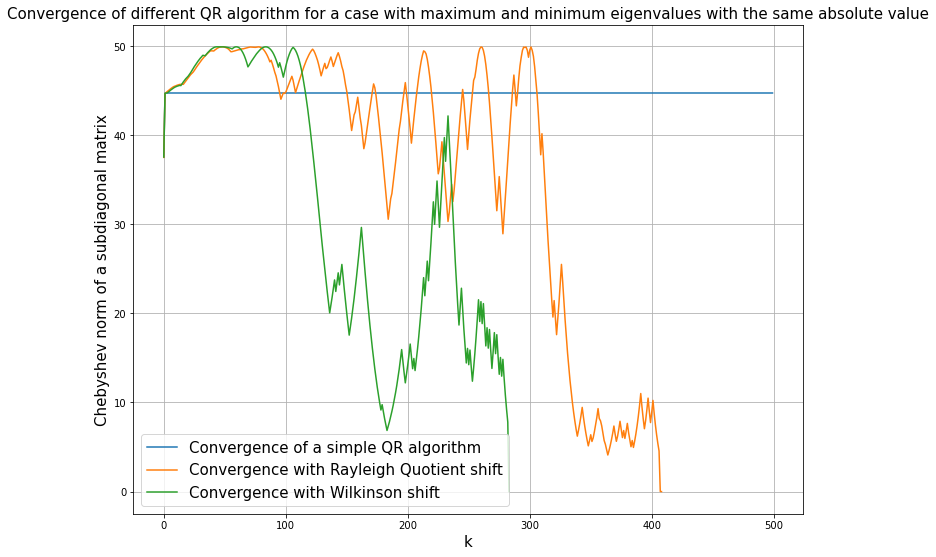

In [63]:
_, conv3 = qr_algorithm(A3, num_iter3)
_, conv3_shift_r, _ = qr_algorithm_reileigh(A3, num_iter3)
_, conv3_shift_w, _ = qr_algorithm_wilkinson(A3, num_iter3)

plt.rcParams['figure.figsize'] = (12, 9)
plt.plot(range(num_iter3), conv3, label='Convergence of a simple QR algorithm')
plt.plot(range(conv3_shift_r.shape[0]), conv3_shift_r, label='Convergence with Rayleigh Quotient shift')
plt.plot(range(conv3_shift_w.shape[0]), conv3_shift_w, label='Convergence with Wilkinson shift')

plt.title('Convergence of different QR algorithm for a case with maximum and minimum eigenvalues with the same absolute value', fontsize=15)
plt.ylabel('Chebyshev norm of a subdiagonal matrix', fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('k', fontsize=15);
plt.grid(True)
#plt.yscale('log')

**So, it happens as it supposed to: convergence with Wilkinson shift is not worse than convergence with Rayleigh Quotient shift. Also, if there is two coincident eigenvalues, then convergence is a bit better. And for case with maximum and minimum eigenvalues with the same absolute value convergence in general is in the same amount of steps as in the case with distinct eigenvalues. Although, it's not so smouth and may be if there is not enough iterations the results may be not as good as in the case with distinct eigenvalues.**

## Problem 4. (Movie Recommender system) 15 pts

Imagine the world without NLA where you have free evenings and you can watch movies!  
But it is always hard to choose a movie to watch. 
In this problem we suggest you to build your own movie recommender system based on SVD decomposition, so you can combine two perfect things: Numerical Linear Algebra and cinematography!

In order to build recommender system you need data. 
Here you are https://grouplens.org/datasets/movielens/1m/

Usually all recommender systems may be devided into two groups

#### Collaborative filtering. 

This approach is based on user-item interaction.
It has one important assumption: user who has liked an item in the past will also likes the same in the future. Suppose the user A likes the films about vampires. 
He is Twilight saga fan and he has watched the film "What we do in the shadows" and liked it or unliked it, in other words he evaluated it somehow. And suppose another user B, who has the similair behavior to the first user (he is also Twilight saga fan). And the chance, that he will estimate "What we do in the shadows" in the same way that user A did, is huge. So, the purpose of the collaborative filtering is to predict a user's behavior based on behavior of the simular users.

#### Content based filtering.

Collaborative filtering has some essential flaws. The main one is called "cold start". "Cold start" happens when the new user comes and he has not react anyhow to the items. So we do not know his past behavior and we do not know what to advise. Here content based filtering helps. Often resources gather some extra info about users and items before a user comes down to utilising the resource. So, for example we would know that user likes horror movies before he watched anything on the resource.


- In this task you will implement Collaborative filtering based on SVD (we will use the function from the proper package and check if the result recommender system advices the similar movies)

1) (1 pts)  Explore the data. Construct the interaction matrix $M$ of size $m \times n$ which contains the information of how a certain user rated a certain film. 

2) (5 pts)  Compute SVD of this matrix. Remeber that matrix $M$ is sparse (one user can hardly watch all the movies) so the good choice would be to use method from ```scipy.sparse.linalg``` package

$$ M = USV^{\top}, $$

where $U$ is a $m \times r $ orthogonal matrix with left singular vectors, which represents the relationship between users and latent factors, $S$ is a $r \times r $ diagonal matrix, which describes the strength of each latent factor and $V^\top$ is a $r \times n$ matrix with right singular vectors, which represent the embeddings of  items (movies in our case) in latent space.
Describe any simple heuristic to choose appropriate value for $r$ and explain why do you expect that it will work.


In [505]:
# Importing Libraries
import numpy as np
import pandas as pd

# Read the datasetp
movies = pd.read_csv('movies.dat',
                     names=['MovieID', 'Title', 'Genres'],
                     dtype=None,
                     engine='python',
                     delimiter="::")
ratings = pd.read_csv('ratings.dat',
                     names=['UserID', 'MovieID', 'Rating', 'Timestamp'],
                     dtype=None,
                     engine='python',
                     delimiter="::")
users = pd.read_csv('users.dat',
                     names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'],
                     dtype=None,
                     engine='python',
                     delimiter="::")

In [506]:
movies.nunique()

MovieID    3883
Title      3883
Genres      301
dtype: int64

In [507]:
ratings.nunique()

UserID         6040
MovieID        3706
Rating            5
Timestamp    458455
dtype: int64

As well there is different number of movies in these dataframes I will "get onto one divider" these dataframes.

In [508]:
for mov_id in movies.MovieID:
    if ratings.loc[ratings.MovieID == mov_id].shape[0] == 0:
        id_2_drop = movies.loc[movies.MovieID == mov_id].index
        movies.drop(index=id_2_drop, axis=0, inplace=True)

In [509]:
movies.nunique()

MovieID    3706
Title      3706
Genres      301
dtype: int64

In [510]:
ratings.nunique()

UserID         6040
MovieID        3706
Rating            5
Timestamp    458455
dtype: int64

Now everthing is alright and we can proceed.

In [511]:
from scipy.sparse import coo_matrix

row = []
col = []
data = []
for i in np.array(ratings.index):
    row.append(ratings.iloc[i].UserID)
    col.append(ratings.iloc[i].MovieID)
    data.append(ratings.iloc[i].Rating)

In [512]:
M = coo_matrix((data, (row, col)))

In [514]:
M.shape

(6041, 3953)

I got the width of an array (3953) which is greater than the inital amount of movies (3706) because of this: not a position index of a movie, but a movie id is used to generate a matrix. It means, the movies that had been dropped previoulsy (or may be one that had come with biased movie id in regard to positional index) has entry in the created matrix, but it's OK as well all these movies has 0 rating for every user. Let's just remeber these movies (will use it in the end).

In [515]:
# nnz_col - array with index (starts with 0) of nonzero coordinate

from scipy import sparse
_, nnz_col, _ = sparse.find(M)
nnz_col = np.unique(nnz_col) - 1   # '-1' to get into numpy way on indexing (from 0)
nnz_col.shape

(3706,)

On Colab I calculated first 2000 largest singular values (see picture below).

For me, the first 50 singular values looks like the most significant. I will go on with $r=50$.

Basically, by truncating matrices with SVD we create latent space (with lower dimensionality). Singular values there represent the strength of each latent factor. As well I take into account "the most significant", I can expect the least loss of information during reduction of dimensionality.

![2000 first largest singular values](https://drive.google.com/uc?export=view&id=1wGqAjfzwp9T5FRKZ5JD0Bg72zQRkbBY6)

In [516]:
# Compute Singular Value Decomposition of interaction matrix. You can use built-in functions
from scipy.sparse.linalg import svds

M = M.asfptype()
U, S, Vh = svds(M, k=50, which='LM') 

In [517]:
S

array([ 147.25027845,  147.63245544,  149.3630054 ,  150.26283681,
        152.62699735,  154.19716431,  154.40629947,  154.68212551,
        156.82360258,  157.63422133,  158.57481793,  161.02664243,
        161.82960128,  163.9679093 ,  164.39979085,  166.39313787,
        166.66230167,  167.93953785,  170.39056208,  173.4545534 ,
        177.40814501,  180.00054896,  182.54076131,  184.35736998,
        187.23251225,  192.34874592,  196.85673474,  199.89552804,
        202.22382818,  211.99396056,  213.28383445,  216.29756551,
        221.72978787,  231.39268055,  239.65266106,  245.51816079,
        253.3454035 ,  256.36631123,  276.37005962,  289.28673298,
        316.08860249,  335.46238645,  346.70684534,  398.74614105,
        426.16540262,  444.85478082,  518.08422502,  574.85275997,
        671.34356538, 1893.21055869])

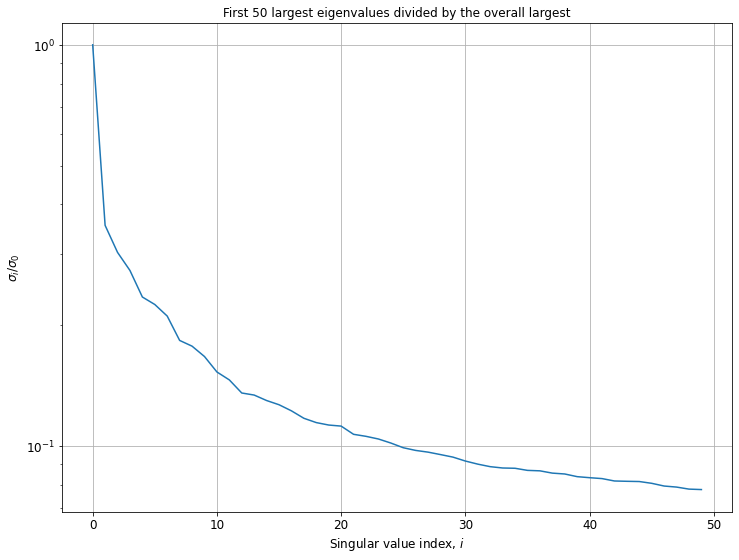

In [518]:
# S is flipped because singular values are in ascending order
import matplotlib.pyplot as plt

plt.semilogy(np.flip(S)/np.flip(S)[0])
plt.rcParams['figure.figsize'] = (12, 9)

plt.title('First 50 largest eigenvalues divided by the overall largest')
plt.ylabel(r"$\sigma_i / \sigma_0$", fontsize=12)
plt.xlabel(r"Singular value index, $i$", fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

3) (2 pts) In order to get weighted item-latent factors, we can multiply $S$ and $V^{T}$. Please, remember that $S$ is diagonal and multiply them efficiently.

In [519]:
# Your solutuion is here
A = np.zeros((S.shape[0], Vh.shape[1]))
for i in range(S.shape[0]):
    A[i, :] = S[i] * Vh[i, :]

print('Tried also an "np.einsum", which took more time')
# A_1 = np.einsum('ij,jk', np.diag(S), Vh)

Tried also an "np.einsum", which took more time


Now we have vectors that represent our item space. In other words we have $N$ movies and $N$ vectors which describe each movie, a.k.a. embeddings. 
In order to know if two movies are similar or not we need just to check if the corresponding vectors are similair or not. How we can do this?

4) (2 pts)  Implement the cosine metric. If the cosine metric between two vectors equals to $1$ both vectors are collinear, if $0$ vectors are orthogonal, as a result corresponding movies are completely different.

$$
cosine(u,v) = \frac{u^{\top}v}{\|u\|_2\|v\|_2}
$$

In [520]:
def cos_metr(u, v):
    cos = np.einsum('i,i', u, v) / (np.linalg.norm(u, 2) * np.linalg.norm(v, 2))
    return cos

5) (5 pts) Check your result. Implement the fuction, which finds and prints $k$ similar movies to the one you have chosen

In [521]:
A.shape

(50, 3953)

In [522]:
# Movie is supposed to be written as in the movies dataframe (with year, all the spaces, etc.)

def similar_movies(movie, k):
    id_cos = []
    simil_title = []
    m_id = movies.loc[movies.Title == movie].MovieID.iloc[0] - 1                        # Id of a choosen mvoeis. MovieID starts with '1', indexing in numpy starts with '0'
    m_vec = A[:, m_id]                                                                  # Find embedding of choosen movie
    
    for i in range(A.shape[1]):
        # With this condition we can skip the movies,
        # which has no rating (but may be has non-zero vectors in latent space).
        # I am not sure if in the latent space moveis, that had no ratings at all
        # will have low simmillarity to a choosen movie. So, I add this condition. 
        if i in nnz_col:
            id_cos.append(cos_metr(m_vec, A[:, i]))                                     # Add cosine metrics for this movie
        else:
            id_cos.append(-3)                                                           # Instead of cosine metrics add the '-3' value for movies, which noone had grated
            
        if i == m_id:                                                                   # Set a value '-1' to itself for metrics to not compare to itslef
            id_cos[-1] = -1
    
    while len(simil_title) < k:
        id_most_sim = np.argmax(id_cos)                                                 # Find the most similar movie
        
        if movies.loc[movies.MovieID == id_most_sim + 1].Title.shape[0] != 0:
            sim_mov = movies.loc[movies.MovieID == id_most_sim + 1].Title.iloc[0]
            simil_title.append(sim_mov)
            
            print(np.amax(id_cos))
            id_cos[np.argmax(id_cos)] = -2                                              # Set metrics equal to '-2' to proceed with the next most similar
     
    print(f'The most similar movies to {movie} in descending order are:\n', simil_title) 

In [523]:
#movies.Title[100: 150]

In [524]:
# From my point of view, this match is pretty good

movie = 'Usual Suspects, The (1995)'
similar_movies(movie, 3)

0.8934847550007375
0.890802025962256
0.8505196422698117
The most similar movies to Usual Suspects, The (1995) in descending order are:
 ['Bhaji on the Beach (1993)', 'Mad Dog Time (1996)', 'Naked Gun 33 1/3: The Final Insult (1994)']


In [525]:
# For historical drama is suggests historical dramas

movie = 'Rob Roy (1995)'
similar_movies(movie, 3)

0.8968360156458957
0.8824668086528968
0.879079123711613
The most similar movies to Rob Roy (1995) in descending order are:
 ['Wings of the Dove, The (1997)', 'Come See the Paradise (1990)', 'Indecent Proposal (1993)']


In [527]:
# I guuess it's a perfect match: movies are melodrama/comdey and about music.

movie = "Lion King, The (1994)"
similar_movies(movie, 3)

0.912837749268319
0.9068833421826691
0.8764104389216408
The most similar movies to Lion King, The (1994) in descending order are:
 ['Threesome (1994)', 'Liberty Heights (1999)', 'Bye Bye, Love (1995)']


In [528]:
# These as good as previous

movie = "Pulp Fiction (1994)"
similar_movies(movie, 3)

0.8784217291404823
0.8284802834415795
0.8257740157302798
The most similar movies to Pulp Fiction (1994) in descending order are:
 ['In the Army Now (1994)', 'Fearless (1993)', 'Mrs. Brown (Her Majesty, Mrs. Brown) (1997)']


**In general, I cannot assess how good are these predictions. I just chose some specific and representative species of genres and comapre it with my understanding.**

Enjoy watching the recommended movies!
